## V00 (For Release)

**Author: S.Sarkar** | **Date: Sep 2025**

This module implements Python Script for probability density estimation and evaluation using various methods: 

* Normal Distribution Estimation
* Pearson Type Estimation (Type -1)
* Tensor-Based Histogram Density Estimation (tHDE)
* Python SciPy Kernel Density Estimation (SciPyKDE)
* Tensor-Based Kernel Density Estimation (tKDE)
* Dual Higher-Order Polynomial Regression (DPR) Using tHDE/tKDE as backend

All the evaluations are done on Synthetic as well as real systolic and diastolic blood pressure data 

It generates synthetic datasets for six unimodal distributions: 

- (1) Symmetric Gaussian, 
- (2) Right-skewed Gaussian, 
- (3) Left-skewed Gaussian, 
- (4) Asymmetric M-Wright 1 (AMW-I), 
- (5) Asymmetric M-Wright 1I (AMW-II), and 
- (6) Asymmetric Laplace distribution (ALD). 

## Include Libraries

In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import beta # For Pearson Type I Dist
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.stats import betaprime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import seaborn as sns


import os
import sys
import gc 

import time
import math

import tensorflow as tf
from tensorflow.keras.backend import clear_session
#*******************************************************************
# Version 
#*******************************************************************
print(f"Python Version: {sys.version}")
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("SciPy version:", scipy.__version__)
print("Panda version:", pd.__version__)
print("Panda version:", pd.__version__)
print("MathplotLib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)


Python Version: 3.8.12 | packaged by conda-forge | (default, Sep 29 2021, 19:21:23) 
[Clang 11.1.0 ]
NumPy version: 1.24.3
TensorFlow version: 2.13.0
SciPy version: 1.10.1
Panda version: 2.0.3
Panda version: 2.0.3
MathplotLib version: 3.7.5
seaborn version: 0.13.2


## Set Path 

In [2]:
import ipynbname
#---------------------------------
ScriptPath = ipynbname.path()
ScriptPath = os.path.dirname(ScriptPath)
print('ScriptPath: ',ScriptPath)
#---------------------------------
ROOT = os.path.abspath(os.path.join(ScriptPath, ".."))
print('ROOT: ',ROOT)
os.chdir(ROOT)
print("Current working directory:", os.getcwd())
#---------------------------------
DATA_PATH = os.path.join(ROOT, "Data")
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print(f'Created folder: {DATA_PATH}')
else:
    print(f'Folder already exists: {DATA_PATH}')
    
#---------------------------------
METRICS_PATH = os.path.join(ROOT, "Metrics")
if not os.path.exists(METRICS_PATH):
    os.makedirs(METRICS_PATH)
    print(f'Created folder: {METRICS_PATH}')
else:
    print(f'Folder already exists: {METRICS_PATH}')
    
#---------------------------------
sys.path.append('./Code')      # Add Code to path
sys.path.append('./Code/Lib')  # Add Code/Lib to path
sys.path.append('./Data')      # Add Data to path

FIG_SAVE_PATH='/Users/shansarkar/Desktop/Paper/PDF/HiResolution/';

ScriptPath:  /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Code
ROOT:  /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc
Current working directory: /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc
Folder already exists: /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data
Folder already exists: /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Metrics


## Load Defined Constants and Custom Functions

In [3]:
#-----------------------------------------
# If Module updated - Use 
if 1:
    # Import Custom Modules
    #import FontDict
    #import DensityEstimate
    #import DualPolyRegPDF
    import ProbabilityDensityFunction

    import importlib
    importlib.reload(ProbabilityDensityFunction)
#-----------------------------------------

# Include Defined Constants and Custom Functions
## Constants - Special Character & Font Definations
from FontDict import GREEK_CHAR, FontNorm9 ,FontNorm10 ,FontNorm11, FontNorm12, SubTitleFont

# SciPyKDE(X, bandwidth=None, s=None, Points=500): Kernel Density Estimation using using the SciPy library’s implementation (scipy.stats.gaussian_kde). (Built on NumPy)
# KDE(X, Bandwidth=None, s=None, Points=500): Kernel Density Estimation using Gaussian kernels (Built on Keras TensorFlow)
# HDE(S, nBins=None, Epsilon=1e-6): Normalized Density Estimation using Histogram (Built on Keras TensorFlow)
from DensityEstimate import SciPyKDE, KDE, HDE, BinsFreedmanDiaconisRule

from DualPolyRegPDF import DualPolyRegPDF

from ProbabilityDensityFunction import GaussianPDF, InvTransformSampling
from ProbabilityDensityFunction import Create_AWM_I_PDF, Create_AWM_II_PDF # M_Wright_Reflect, M_CDF, 
from ProbabilityDensityFunction import AsymLaplacePDF, SampleAsymLaplace



## Macros

In [4]:
TEST_CODE= False # Used to debug (Default False)
SAVE_FILES = False

SEED= 42
nSAMPLES = 200000 # Total Samples
nPDF = 10000 # Total Samples
PROB_FUNC_TH=5

muMIN=-0.5; muMAX=0.5
xMIN=-10; xMAX=10
vMIN=2; vMAX=3
aMIN=2; aMAX=3
nuMIN=0.15; nuMAX=0.35
lMIN=1; lMAX=2;
kMIN=1.2; kMAX=1.8;

DIST_USED = ["Gaussian-Symmetric", "Gaussian-Right-skewed", "Gaussian-Left-skewed"]+\
            ["Asymmetric-M-Wright-I", "Asymmetric-M-Wright-II", "Asymmetric-Laplace"]

REAL_DATA_FILE = "Systolic_Diastolic_Data.xlsx"

POLY_ORDERS=[3,4,5,6,7]
# Must have x 2 colors codes 
POLY_ORDER_COLORS=['blue', 'green','cyan', 'magenta', 'lime', 'orange','purple','pink','brown','teal']

SIGNIFICANT_ALPHA=0.01 # Alpha



## Function to Reset Keras BackEnd

In [5]:
def ResetBackEnd():
    gc.collect();
    clear_session()
    tf.keras.backend.clear_session();
    gc.collect();
    
    # Set the Seed            
    np.random.seed(SEED); #Set Seed Value 
    tf.random.set_seed(SEED);
    tf.keras.utils.set_random_seed(SEED);
ResetBackEnd()

## For Evaluation / Debugging Purpose - DualPolyRegPDF()

**To make sure Function is working. It confirms all following functions are working perfect:** 
* DualPolyRegPDF() & Callable Return Function
* KDE()
* HDE()

In [6]:
if TEST_CODE: 
    np.random.seed(SEED)
    fig, bx = plt.subplots(1, 1, figsize=(9, 9));
    data = np.random.normal(loc=0.5, scale=1.5, size=10000)
    print(f'std: {np.std(data):.3f}')
    data_tf = tf.constant(data, dtype=tf.float32)

    cases = [   {"UseKDE": True,  "RetProb": True,  "label": "Case 1: KDE + RetProb=True"},
                {"UseKDE": True,  "RetProb": False, "label": "Case 2: KDE + RetProb=False"},    
                {"UseKDE": False, "RetProb": True,  "label": "Case 3: HDE + RetProb=True"},
                {"UseKDE": False, "RetProb": False, "label": "Case 4: HDE + RetProb=False"},]

    for case in cases:
        print("\n" + "="*80)
        print(case["label"])
        print("="*80)

        result = DualPolyRegPDF(
                                Superset=data_tf,
                                Points=nPDF,
                                PolyOrder=5,
                                TimesStd=PROB_FUNC_TH,
                                UseKDE=case["UseKDE"],
                                RetProb=case["RetProb"],
                                Print=True
                               )

        if case["RetProb"]:
            # result is (x, y)
            x_fit, y_fit = result
        else:
            # result is a callable function → compute probabilities
            func = result
            x_fit = np.linspace(np.min(data), np.max(data), 200).astype(np.float32)
            yHat = func(tf.constant(x_fit, dtype=tf.float32))
            y_fit =yHat.numpy()

        auc = np.trapz(y_fit, x_fit)
        print("AUC (np.trapz(y_fit, x_fit)):", auc)

        bx.plot(x_fit, y_fit, label=case["label"])

    bx.set_title("Comparison of CreateFunc4PDF Cases")
    bx.set_xlabel("x")
    bx.set_ylabel("PDF")
    bx.legend()
    plt.show();


## Function to Compute area under the curve (AUC) - Using Tensorflow

$$
\text{AUC} = \sum_{i=1}^{N-1} (x_{i+1} - x_i) \cdot \frac{P_{i+1} + P_i}{2}
$$

where

- $x_i$ are sorted input values,
- $P_i$ are the corresponding probability or density values,
- and $N$ is the total number of points.

In [7]:
# -----------------------------------------------------------------------------
# ComputeAUC: Estimates the area under a 1D curve using the trapezoidal rule.
#
# Inputs:
#   x : 1D tensor of x-values (must be sorted).
#   P : 1D tensor of corresponding probability or density values.
#
# Computes dx between consecutive x-values and integrates by averaging adjacent
# P values. Useful for verifying if a PDF integrates to ~1.
#
# Returns:
#   auc : Scalar tensor representing the estimated area under the curve.
# -----------------------------------------------------------------------------

def ComputeAUC(x, P):
    x = tf.cast(x, tf.float32)
    P = tf.cast(P, tf.float32)
    
    dx = x[1:] - x[:-1]
    avg_P = (P[1:] + P[:-1]) / 2.0
    auc = tf.reduce_sum(dx * avg_P)
    return auc

## Compute JS-Divergence

In [8]:
# -----------------------------------------------------------------------------
# ComputeJSD: Computes the Jensen-Shannon Divergence (JSD) between two 
# probability distributions P and Q using TensorFlow operations.
#
# - Ensures numerical stability by clipping values to avoid log(0).
# - Computes the average distribution M = 0.5*(P + Q).
# - Uses the KL divergence formula to calculate JSD:
#       JSD(P || Q) = 0.5 * KL(P || M) + 0.5 * KL(Q || M)
# - Returns scalar JSD value; optionally prints intermediate shapes and values.
# - Supports both float32 and float64 precision.
# -----------------------------------------------------------------------------
def ComputeJSD(P,Q,epsilon=1e-12,PrintFlag = False):
    # Convert both tensors to the same dtype (float32 or float64)
    dtype = tf.float32  # or tf.float64 depending on your preference
    P = tf.cast(P, dtype)
    Q = tf.cast(Q, dtype)
    
    # Normalize so sums = 1
    P = P / tf.reduce_sum(P, axis=-1, keepdims=True)
    Q = Q / tf.reduce_sum(Q, axis=-1, keepdims=True)
    
    #  Clip to avoid log(0)
    P = tf.clip_by_value(P, epsilon, 1.0)
    Q = tf.clip_by_value(Q, epsilon, 1.0)
    #tf.print("P shape:", tf.shape(P), " Q shape:", tf.shape(Q))
    # Average distribution
    M = 0.5 * (P + Q)
    M = tf.clip_by_value(M, epsilon, 1.0)

    # KL divergences
    kl_P = tf.reduce_sum(P * tf.math.log(P / M), axis=-1)
    kl_Q = tf.reduce_sum(Q * tf.math.log(Q / M), axis=-1)

    # Jensen–Shannon divergence
    jsd = 0.5 * (kl_P + kl_Q)  
    # Ensure numerical positivity 
    jsd = tf.maximum(jsd, 0.0)
    
    if PrintFlag:
        tf.print("P shape:", tf.shape(P), " Q shape:", tf.shape(Q), " M shape:", tf.shape(M))
        tf.print("kl_P :", kl_P, " kl_Q:", kl_Q)
        tf.print("JSD :", jsd)

    return jsd 


## Compute Pearson correlation coefficient using  TensorFlow


In [9]:
def ComputePearsonCorr(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.float32)
    
    x_mean = tf.reduce_mean(x)
    y_mean = tf.reduce_mean(y)
    
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = tf.reduce_sum(x_centered * y_centered)
    denominator = tf.sqrt(tf.reduce_sum(tf.square(x_centered)) * tf.reduce_sum(tf.square(y_centered)))
    
    return numerator / denominator


## Tensorflow Func to Compute Prob from Normal Dist Estimation

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2 \right)
$$

In [10]:
def NormPDF(x, mu, Sigma, epsilon=1e-12):
    """
    Compute the Normal (Gaussian) probability density function.

    Args:
        x: tf.Tensor or float, points at which to evaluate the PDF.
        mu: tf.Tensor or float, mean of the Normal distribution.
        Sigma: tf.Tensor or float, standard deviation (sigma > 0).
        epsilon: small float to avoid division by zero.

    Returns:
        tf.Tensor: PDF values of the Normal distribution at x.
    """    
    # Ensure mu and Sigma are tensors for compatibility with Keras/TensorFlow
    mu = tf.convert_to_tensor(mu, dtype=tf.float32)
    Sigma = tf.convert_to_tensor(Sigma, dtype=tf.float32)
    # Avoid division by zero
    Sigma = tf.maximum(Sigma, epsilon)
    # Calculate the PDF of a Normal distribution using the formula
    # f(x) = (1 / (Sigma * sqrt(2 * pi))) * exp(-0.5 * ((x - mu) / Sigma)^2)
    
    pi = tf.constant(np.pi, dtype=tf.float32)
    coefficient = 1 / (Sigma * tf.sqrt(2 * pi))
    exponent = -0.5 * tf.square((x - mu) / Sigma)
    y = coefficient * tf.exp(exponent)

    return y


if TEST_CODE: 
    # Generate normal distribution data
    mu = 0
    sigma = 1
    samples = np.random.normal(mu, sigma, 1000)
    x_vals = np.linspace(-4, 4, 500)

    # Compute PDF using NumPy
    pdf_numpy = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - mu) / sigma)**2)

    # Compute PDF using TensorFlow
    x_tensor = tf.convert_to_tensor(x_vals, dtype=tf.float32)
    pdf_tensorflow = NormPDF(x_tensor, mu, sigma).numpy()

    # Plot histogram and both PDFs
    plt.figure(figsize=(10, 6))
    plt.hist(samples, bins=30, density=True, alpha=0.5, label='Histogram of Samples')
    plt.plot(x_vals, pdf_numpy, 'r-', lw=2, label='NumPy PDF')
    plt.plot(x_vals, pdf_tensorflow, 'b--', lw=2, label='TensorFlow PDF')
    plt.title('Normal Distribution PDF Comparison')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()


## Types of Pearson Distributions 

| Type    | Description                                                             |
| ------- | ----------------------------------------------------------------------- |
| **I**   | **Beta distribution** on a finite interval, skewed; bounded both sides. |
| **II**  | **Symmetric Beta** on a finite interval; bell-shaped, bounded.          |
| **III** | **Gamma / Chi-squared** type; skewed, non-negative support.             |
| **IV**  | Skewed, heavy-tailed distribution on the whole real line.               |
| **V**   | **Inverse Gamma** type; heavy-tailed, positive-only.                    |
| **VI**  | **Beta prime** type; positive-only, two shape parameters.               |
| **VII** | Symmetric, Student’s t-like heavy tails on the real line.               |




| Type | $\kappa$-Criterion | Density Function $f(x)$                         |       Domain          |
|:----:|:------------------:|:-----------------------------------------------:|:---------------------:|
| I    | $$\kappa < 0$$     | $$y_0(1+x/a_1)^{m_1}(1 - x/a_2)^{m_2}$$         | $$-a_1 \le x \le a_2$$  |
| IV   | $$0 < \kappa < 1$$ | $$y_0 (1 + x^2/a^2)^{-m} e^{-\nu \arctan(x/a)}$$| $$-\infty < x < \infty$$|
| VI   | $$\kappa > 1$$     | $$y_0 (x - a)^{q_2} x^{-q_1}$$                  | $$a \le x < \infty$$    |



| Type | $\kappa$-Criterion | Density Function $f(x)$ | Domain |
| ---- | ----------------- | ---------------------- | ------ |
| Normal | $$\kappa=0(\beta_2=3)$$ | $$f(x)=y_0 e^{-x^2/(2\mu_2)}$$ | $$-\infty<x<\infty$$ |
| II     | $$\kappa=0(\beta_2<3)$$ | $$f(x)=y_0 (1-x^2/a^2)^m$$ | $$-a\le x\le a$$ |
| III    | $$\kappa=\pm\infty$$ | $$f(x)=y_0 (1+x/a)^{\gamma_a} e^{-\gamma x}$$ | $$-a\le x<\infty$$ |
| V      | $$\kappa=1$$ | $$f(x)=y_0 x^{-p} e^{-\gamma/x}$$ | $$0<x<\infty$$ |
| VII    | $$\kappa=0(\beta_2>3)$$ | $$f(x)=y_0 (1+x^2/a^2)^{-m}$$ | $$-\infty<x<\infty$$ |



### Pearson Discriminant ($\kappa$)  

The Pearson discriminant is defined as:

$\kappa = \beta_2 - \frac{3}{2} \beta_1 - 3$

where the moments are:

$\beta_1 = \gamma_1^2 = \left(\frac{\mu_3}{\sigma^3}\right)^2$  (squared skewness)

$\beta_2 = \frac{\mu_4}{\sigma^4}$  (kurtosis)

- $\mu_3$ is the third central moment (measures skewness)  
- $\mu_4$ is the fourth central moment (measures kurtosis)  
- $\sigma$ is the standard deviation  

The value of $\kappa$ determines the type of Pearson distribution based on the skewness and kurtosis of the data.


* The normal distribution is referred as the Pearson‐0 distribution

* In principle, maximum likelihood estimates for each of the shape parameters can be then determined from the distribution’s moments. **So Using Moments from Org PDF** 

King, Myke. “Pearson Distribution.” Statistics for Process Control Engineers, John Wiley & Sons, Ltd, 2017, pp. 415–34, https://doi.org/10.1002/9781119383536.ch27.


In [11]:
#========================================================================
# Check Pearson distribution types based on skew and kurtosis.
#========================================================================
def GetPearsonType(x):
    """
    Classifies data into Pearson distribution types based on skewness and kurtosis.
    
    Args:
        x (1D array):  PDF
    Returns:
        str: Pearson type.
    """
    
     # Compute mean
    Mu = np.mean(x)

    # Compute central moments
    cM2 = np.mean((x - Mu)**2)   # variance
    cM3 = np.mean((x - Mu)**3)   # skewness numerator
    cM4 = np.mean((x - Mu)**4)   # kurtosis numerator
    print("\n************************************************************")
    print(f"Mu:{Mu:.3f} Central Moments 2:{cM2:.3f} 3:{cM3:.3f}  4:{cM4:.3f}")
    # β1 = μ3^2 /μ2^3   ; β2 = μ4 /μ2^2 
    
    beta1 = (cM3**2) / (cM2**3)
    beta2 = cM4 / (cM2**2)
    # Calculate kappa (discriminant)
    kappa = np.round(beta2 - (3/2) * beta1 - 3, 3)
    gamma1 = np.sqrt(beta1)  # skewness
    rBeta2=np.round(beta2,1)
    print(f"Pearson constants β1: {beta1:.3f}, β2: {rBeta2:.2f} κ: {kappa:.3f}  γ1:{gamma1:.3f} ")   

    # Skewed cases
    if np.abs(kappa) < 0.01: #==0
        if  rBeta2<3: 
            print("Type II (Symmetric Beta on a finite interval; bell-shaped, bounded.)")
            return 2
        if  rBeta2 > 3: 
            print("Type VII (Symmetric, Student’s t-like heavy tails on the real line.)")
            return 7
        else: #==3
            print("Type 0 (Normal distribution.)")
            return 0
    
    elif kappa < 0:
        print("Type I (Beta distribution on a finite interval, skewed; bounded both sides.)")
        return 1
    elif kappa > 0 and kappa < 1:
        print("Type IV (Skewed, heavy-tailed distribution on the whole real line. )")
        return 4
    elif kappa > 1:
        print("Type VI (Beta prime type; positive-only, two shape parameters.)")
        return 6    
    elif kappa == 1:
        print("Type V (Inverse Gamma type; heavy-tailed, positive-only.)")
        return 5    
    elif np.abs(kappa) == 1e6: #inf
        print("Type III (Gamma / Chi-squared type; skewed, non-negative support)")
        return 3     
    else:
        print("Unable to detect Type)")
        return None
        


## Estimates the Pearson Type I PDF

$$
f(x) = \frac{1}{ B(\delta_1, \delta_2)} \left(\frac{x - \alpha}{\beta}\right)^{\delta_1 - 1} \left(1 - \frac{x - \alpha}{\beta}\right)^{\delta_2 - 1}, \quad \text{for } \alpha \leq x \leq \alpha + \beta
$$

Here $B(\delta_1,\delta_2)$ is the Beta function:
$$
B(\delta_1,\delta_2) = \int_0^1 t^{\delta_1-1} (1 - t)^{\delta_2-1} dt = \frac{\Gamma(\delta_1) \Gamma(\delta_2)}{\Gamma(\delta_1+\delta_2)}
$$
and $\delta_1,\delta_2,\beta\ >\ 0$.


The standard Beta distribution is defined over $[0, 1]$, and its PDF is normalized by $B(\delta_1, \delta_2)$.

When you scale the domain to $[\alpha, \alpha + \beta]$, one must include the Jacobian of the transformation, which introduces the extra $\frac{1}{\beta}$ factor to preserve total probability.


In [12]:
#========================================================================
# Computes the PDF for Pearson Type I distribution
# The Pearson‐I distribution can also be described as the beta‐I distribution
#========================================================================
def Pearson_I_PDF(S,x):
    """
    Computes the Pearson Type IV PDF.

    Parameters
    ----------
    S : array-like Population
    x : array-like Points to evaluate the PDF.
    
    Returns
    -------
    pdf : array-like PDF values at x.
    """

    # Adding slight margin to avoid warning 
    loc_hat = np.min(S) - 1e-6
    scale_hat = np.ptp(S) + 2e-6
    # Fit Beta distribution
    alpha_hat, beta_hat, loc_hat, scale_hat = beta.fit(S,floc=loc_hat, fscale=scale_hat)
    # Evaluate PDF
    pdf = beta.pdf(x, alpha_hat, beta_hat, loc=loc_hat, scale=scale_hat)    

    return pdf

if TEST_CODE:
    # Example usage
    S = np.random.normal(loc=0, scale=1, size=1000)  # Simulated dataset
    x = np.linspace(-5, 5, 500)
    pdf_vals = Pearson_I_PDF(S, x)

    # Sort x and pdf for smooth plotting
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    pdf_sorted = pdf_vals[sorted_indices]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_sorted, pdf_sorted, lw=2)
    plt.title("Pearson Type I PDF")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.show()


## Function to Estimate Pearson Type IV PDF

In [13]:
def Pearson_IV_PDF(S, x):
    """
    Computes the Pearson Type IV PDF.

    Parameters
    ----------
    S : array-like
        Sample population used to estimate distribution parameters.
    x : array-like
        Points at which to evaluate the PDF.
    
    Returns
    -------
    pdf : array-like
        PDF values at x.
    """

    # Mean and central moments
    mu = np.mean(S)
    c2 = np.mean((S - mu)**2)   # variance
    c3 = np.mean((S - mu)**3)   # skewness numerator
    c4 = np.mean((S - mu)**4)   # kurtosis numerator

    # Standardized moments
    gamma1 = c3 / c2**1.5        # skewness
    gamma2 = c4 / c2**2 - 3      # excess kurtosis

    # Validate gamma2
    if gamma2 <= 0:
        raise ValueError("Excess kurtosis (gamma2) must be positive for Pearson Type IV distribution.")

    # Parameters
    alpha = mu  # location
    delta1 = (3 + gamma2) / (2 * gamma2)  # shape
    delta2 = (3 * gamma1) / (2 * gamma2)  # skewness
    beta = np.sqrt(c2 * (2 * delta1 - 1) / delta1)  # scale

    # Normalization constant
    K = np.abs(gamma(delta1 + 1j * delta2))**2 / (beta * gamma(2 * delta1))

    # PDF computation
    z = (x - alpha) / beta
    pdf = K * (1 + z**2)**(-delta1) * np.exp(-delta2 * np.arctan(z))
    return pdf

if TEST_CODE:
    # Example usage
    S = np.random.normal(loc=0, scale=1, size=1000)  # Simulated dataset
    x = np.linspace(-5, 5, 500)
    pdf_vals = Pearson_IV_PDF(S, x)

    # Sort x and pdf for smooth plotting
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    pdf_sorted = pdf_vals[sorted_indices]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_sorted, pdf_sorted, lw=2)
    plt.title("Pearson Type IV PDF (Valid Parameters)")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.show()


## Function to Estimate Pearson Type VI PDF

In [14]:
def Solve_delta2(d2, mu_Y, var_Y, beta):
    d1 = mu_Y * (d2 - 1) / beta
    return beta**2 * d1*(d1 + d2 - 1) / ((d2 - 2)*(d2 - 1)**2) - var_Y

def Pearson_VI_PDF(S, x):    
    alpha = np.min(S)
    Y = S - alpha
    mu_Y = np.mean(Y)
    var_Y = np.var(Y)
    
    beta_init = mu_Y
    delta2_guess = 5.0
    delta2 = fsolve(Solve_delta2, delta2_guess, args=(mu_Y, var_Y, beta_init))[0]
    delta1 = mu_Y * (delta2 - 1) / beta_init
    
    beta_scale = np.mean(Y) / (delta1 / (delta2 - 1))
    
    # Ensure evaluation points are above alpha
    x_valid = np.maximum(x, alpha + 1e-8)
    
    pdf = betaprime.pdf((x_valid - alpha)/beta_scale, delta1, delta2) / beta_scale
    return pdf, alpha, beta_scale, delta1, delta2

if TEST_CODE: 
    # Example dataset
    S = np.random.beta(2.0, 3.0, size=1000) * 5.0 + 1.0  # shifted & scaled beta-prime like

    # x values
    x_grid = np.linspace(np.min(S), np.max(S)+5, 500)
    pdf, alpha, beta_scale, delta1, delta2 = Pearson_VI_PDF(S, x_grid)

    plt.plot(x_grid, pdf, lw=2)
    plt.title("Pearson Type VI PDF")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.show()

    print("alpha:", alpha)
    print("beta_scale:", beta_scale)
    print("delta1:", delta1)
    print("delta2:", delta2)


## Function to update Dataframe

In [15]:
# UpdateDf updates an existing row in the DataFrame if a match is found for
# both 'Distribution' and 'Function'; otherwise, it appends a new row.
#
# UpdateDf(df, distribution, function, memory_kb, training_time, inference_time, auc, js_divergence)
# 
# Args:
#   df (pd.DataFrame): The input DataFrame with performance metrics.
#   distribution (str): Name of the distribution type (e.g., 'KDE').
#   function (str): Name of the function or estimator used.
#   memory_kb (float): Memory usage in kilobytes.
#   training_time (float): Time taken for training.
#   inference_time (float): Time taken for inference/prediction.
#   auc (float): Area Under the Curve (AUC) metric.
#   js_divergence (float): Jensen-Shannon divergence value.
#
# Returns:
#   pd.DataFrame: Updated DataFrame with the new or modified row.

def UpdateDf(df, distribution, function, training_time, inference_time, auc, js_divergence, mse, corr): 
    
    # Check if a row with the given distribution and function already exists
    Mask = (df['Distribution'] == distribution) & (df['Function'] == function)

    if Mask.any():
        Idx = df.index[Mask][0]  # Get the row index
        print(f'Idx:{Idx} ')#Mask: {mask}
        # Update the existing row
        df.at[Idx, 'Training'] = float(training_time) if training_time is not None else np.nan
        df.at[Idx, 'Inference'] = float(inference_time) if inference_time is not None else np.nan
        df.at[Idx, 'AUC'] = float(auc) if auc is not None else np.nan
        df.at[Idx, 'JS-Divergence'] = float(js_divergence) if js_divergence is not None else np.nan
        df.at[Idx, 'MSE'] = float(mse) if mse is not None else np.nan
        df.at[Idx, 'Correlation'] = float(corr) if corr is not None else np.nan
    else:
        # Add a new row
        new_row = {
            'Distribution': distribution,
            'Function': function,
            'Training': float(training_time) if training_time is not None else np.nan,
            'Inference': float(inference_time) if inference_time is not None else np.nan,
            'AUC': float(auc) if auc is not None else np.nan,
            'JS-Divergence': float(js_divergence) if js_divergence is not None else np.nan,
            'MSE': float(mse) if mse is not None else np.nan,
            'Correlation': float(corr) if corr is not None else np.nan
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df
#------------------------------------------------------------ 
# Create empty DataFrame
#------------------------------------------------------------ 
# Define column names
columns = ['Distribution', 'Function', 'Training', 'Inference', 'AUC','JS-Divergence', 'MSE', 'Correlation']  
df = pd.DataFrame(columns=columns)
display(df)

,Distribution,Function,Training,Inference,AUC,JS-Divergence,MSE,Correlation


## Function to Save and Load Data

In [16]:
def SaveData(S, filename, path=DATA_PATH):
    """
    Save tensor/array S as a numpy .npy file under data_path/filename.
    Converts tensor to numpy array if needed.
    Deletes numpy copy after saving to free memory.
    
    Args:
        S: Tensor or numpy array to save.
        filename: String filename (with or without .npy extension).
        data_path: Directory path where file will be saved.
    """
    # Ensure directory exists
    os.makedirs(path, exist_ok=True)
    
    # Convert to numpy array if tensor
    S_np = S.numpy() if hasattr(S, 'numpy') else np.array(S)
    
    # Add .npy extension if missing
    if not filename.endswith('.npy'):
        filename += '.npy'
    
    filepath = os.path.join(path, filename)
    
    # Save numpy array
    np.save(filepath, S_np)
    print(f"Saved {filepath}")
    
    # Delete numpy copy and force garbage collection
    del S_np
    gc.collect()
#**************************************************    
def LoadData(filename, path=DATA_PATH):
    """
    Load a numpy .npy file from the specified path.

    Args:
        filename: Filename string (with or without .npy extension).
        path: Directory path where the file is located (default DATA_PATH).

    Returns:
        Loaded numpy array.
    """
    if not filename.endswith('.npy'):
        filename += '.npy'
    filepath = os.path.join(path, filename)

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    S = np.load(filepath)
    print(f"Loaded {filepath}")
    return S


## Comparison of Prob. Density Estimation Methods Across Different Gaussian Dist.

This code generates synthetic data from three Gaussian distributions with varying skewness and compares multiple probability density estimation techniques, including SciPy KDE, Histogram-based density estimation (HDE), and a custom Dual Polynomial Regression method using Polynomial order 3-7. Performance metrics such as AUC, Jensen-Shannon Divergence, and MSE are computed and visualized for each method across the distributions.

**Note: Cholesky decomposition for higher Order $\ge 5$ failed in some cases**


********************************************************
Case 1: Gaussian-Symmetric
********************************************************
  μ = 0.04881350392732475
  σ = sqrt(2.715) = 1.648
  α = 0.000

Metal device set to: Apple M1 Max
Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Symmetric.npy
x:(10000,)  PDF:(10000,) s:(200000,) AUC: 1.00


2025-10-02 13:30:20.592085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-02 13:30:20.592106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-02 13:30:21.012055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00144  msTime:228.31 JSD: 0.03  AUC: 1.00 MSE:0.001 Corr:0.967
Norm:(10000,) Norm pdf:(10000,)  msTime:28.02  JSD:0.00 AUC:1.00, MSE:0.000 Corr:1.000

************************************************************
Mu:0.050 Central Moments 2:0.006 3:0.001  4:0.000
Pearson constants β1: 1.947, β2: 3.40 κ: -2.488  γ1:1.395 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:3.48  JSD:0.00 AUC:1.00, MSE:0.000 Corr:0.999
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:7422.26  JSD:0.03 AUC:1.00, MSE:0.001 Corr:0.969


2025-10-02 13:30:32.775174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:182.91  JSD:0.03 AUC:1.00 MSE:0.001 Corr:0.969

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:30:34.216724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:30:42.862291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8436.97 msTime:127.89


2025-10-02 13:30:43.191980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:30:51.720767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8323.83 msTime:38.45
pdfFunc:(10000,)   msTrain:8323.83 msTime:38.45  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.997


2025-10-02 13:30:52.126831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:00.588950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8243.35 msTime:50.57
pdfFunc:(10000,)   msTrain:8243.35 msTime:50.57  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.997


2025-10-02 13:31:00.987297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:09.561852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8354.25 msTime:50.34
pdfFunc:(10000,)   msTrain:8354.25 msTime:50.34  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:31:10.004374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:18.633752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8413.87 msTime:55.18
pdfFunc:(10000,)   msTrain:8413.87 msTime:55.18  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:31:19.078135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:27.006278: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


2025-10-02 13:31:27.693236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8401.29 msTime:53.80
pdfFunc:(10000,)   msTrain:8401.29 msTime:53.80  JSD:0.29 AUC:4.86 MSE:0.043 Corr:0.000

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:31:28.168607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:29.577184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:1233.55 msTime:41.44


2025-10-02 13:31:29.919207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:31.061355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:949.12 msTime:39.69
pdfFunc:(10000,)   msTrain:949.12 msTime:39.69  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.997


2025-10-02 13:31:31.516789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:32.945739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1253.02 msTime:40.61
pdfFunc:(10000,)   msTrain:1253.02 msTime:40.61  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.997


2025-10-02 13:31:33.427712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:34.885870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1276.91 msTime:41.62
pdfFunc:(10000,)   msTrain:1276.91 msTime:41.62  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:31:35.378095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:36.836918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1277.31 msTime:41.22
pdfFunc:(10000,)   msTrain:1277.31 msTime:41.22  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:31:37.326328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:31:38.804014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:1298.46 msTime:41.78
pdfFunc:(10000,)   msTrain:1298.46 msTime:41.78  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000

********************************************************
Case 2: Gaussian-Right-skewed
********************************************************
  μ = -0.1254598811526375
  σ = sqrt(2.951) = 1.718
  α = 2.732

Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Right-skewed.npy
x:(10000,)  PDF:(10000,) s:(200000,) AUC: 1.00


2025-10-02 13:31:39.421097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00099  msTime:85.73 JSD: 0.44  AUC: 1.00 MSE:0.031 Corr:-0.064
Norm:(10000,) Norm pdf:(10000,)  msTime:67.43  JSD:0.13 AUC:1.00, MSE:0.005 Corr:0.739

************************************************************
Mu:0.050 Central Moments 2:0.010 3:0.002  4:0.001
Pearson constants β1: 4.324, β2: 6.00 κ: -3.508  γ1:2.079 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:3.69  JSD:0.00 AUC:1.00, MSE:0.000 Corr:0.993
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:7325.13  JSD:0.44 AUC:1.00, MSE:0.031 Corr:-0.063


2025-10-02 13:31:51.581130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:47.69  JSD:0.44 AUC:1.00 MSE:0.031 Corr:-0.063

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:31:52.812563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:01.565355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8495.63 msTime:40.90


2025-10-02 13:32:02.039906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:10.807555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8476.47 msTime:42.63
pdfFunc:(10000,)   msTrain:8476.47 msTime:42.63  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.998


2025-10-02 13:32:11.387155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:20.105425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8427.75 msTime:42.32
pdfFunc:(10000,)   msTrain:8427.75 msTime:42.32  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.998


2025-10-02 13:32:20.687880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:29.451504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8469.01 msTime:42.50
pdfFunc:(10000,)   msTrain:8469.01 msTime:42.50  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:32:30.020306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:38.800284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8464.76 msTime:47.57
pdfFunc:(10000,)   msTrain:8464.76 msTime:47.57  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:32:39.468036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:47.456243: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:32:48.323411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8583.64 msTime:45.98
pdfFunc:(10000,)   msTrain:8583.64 msTime:45.98  JSD:0.37 AUC:7.55 MSE:0.118 Corr:nan

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:32:49.005984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:51.080731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:1834.98 msTime:45.79


2025-10-02 13:32:51.576692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:53.204186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:1366.41 msTime:45.20
pdfFunc:(10000,)   msTrain:1366.41 msTime:45.20  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.998


2025-10-02 13:32:53.883043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:55.519663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1374.09 msTime:46.45
pdfFunc:(10000,)   msTrain:1374.09 msTime:46.45  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.998


2025-10-02 13:32:56.215465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:32:57.842117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1362.81 msTime:45.01
pdfFunc:(10000,)   msTrain:1362.81 msTime:45.01  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:32:58.536117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:00.189559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1394.13 msTime:43.61
pdfFunc:(10000,)   msTrain:1394.13 msTime:43.61  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:33:00.934496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:02.580695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:1387.57 msTime:43.90
pdfFunc:(10000,)   msTrain:1387.57 msTime:43.90  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000

********************************************************
Case 3: Gaussian-Left-skewed
********************************************************
  μ = -0.4539590063685145
  σ = sqrt(2.370) = 1.540
  α = -2.242

Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Left-skewed.npy
x:(10000,)  PDF:(10000,) s:(200000,) AUC: 1.00


2025-10-02 13:33:03.443751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00094  msTime:93.86 JSD: 0.47  AUC: 1.00 MSE:0.035 Corr:-0.095
Norm:(10000,) Norm pdf:(10000,)  msTime:65.30  JSD:0.12 AUC:1.00, MSE:0.005 Corr:0.767

************************************************************
Mu:0.050 Central Moments 2:0.011 3:0.003  4:0.001
Pearson constants β1: 4.752, β2: 6.40 κ: -3.706  γ1:2.180 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:2.99  JSD:0.00 AUC:1.00, MSE:0.000 Corr:0.995
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:7761.59  JSD:0.47 AUC:1.00, MSE:0.035 Corr:-0.094


2025-10-02 13:33:16.518839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:188.19  JSD:0.47 AUC:1.00 MSE:0.035 Corr:-0.094

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:33:18.259069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:27.225508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8592.72 msTime:43.21


2025-10-02 13:33:27.818605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:36.739510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8554.61 msTime:46.74
pdfFunc:(10000,)   msTrain:8554.61 msTime:46.74  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:33:37.514213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:46.493228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8604.86 msTime:45.29
pdfFunc:(10000,)   msTrain:8604.86 msTime:45.29  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:33:47.269139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:33:56.240843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8602.92 msTime:45.96
pdfFunc:(10000,)   msTrain:8602.92 msTime:45.96  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:33:57.015650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:04.976227: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:34:05.965479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8579.84 msTime:45.34
pdfFunc:(10000,)   msTrain:8579.84 msTime:45.34  JSD:0.39 AUC:7.95 MSE:0.132 Corr:nan


2025-10-02 13:34:06.736570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:14.735644: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:34:15.725767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8620.63 msTime:46.63
pdfFunc:(10000,)   msTrain:8620.63 msTime:46.63  JSD:0.39 AUC:7.95 MSE:0.132 Corr:nan

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:34:16.492284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:18.695700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:1839.73 msTime:45.25


2025-10-02 13:34:19.290823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:20.991860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:1337.26 msTime:45.29
pdfFunc:(10000,)   msTrain:1337.26 msTime:45.29  JSD:0.01 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:34:21.822454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:23.554480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1360.16 msTime:48.43
pdfFunc:(10000,)   msTrain:1360.16 msTime:48.43  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:34:24.343307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:26.103458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1371.23 msTime:65.11
pdfFunc:(10000,)   msTrain:1371.23 msTime:65.11  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:34:26.875071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:28.685233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1387.93 msTime:101.73
pdfFunc:(10000,)   msTrain:1387.93 msTime:101.73  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:34:29.450926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:34:30.248818: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:34:31.326516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:1509.29 msTime:50.58
pdfFunc:(10000,)   msTrain:1509.29 msTime:50.58  JSD:0.39 AUC:7.92 MSE:0.131 Corr:nan


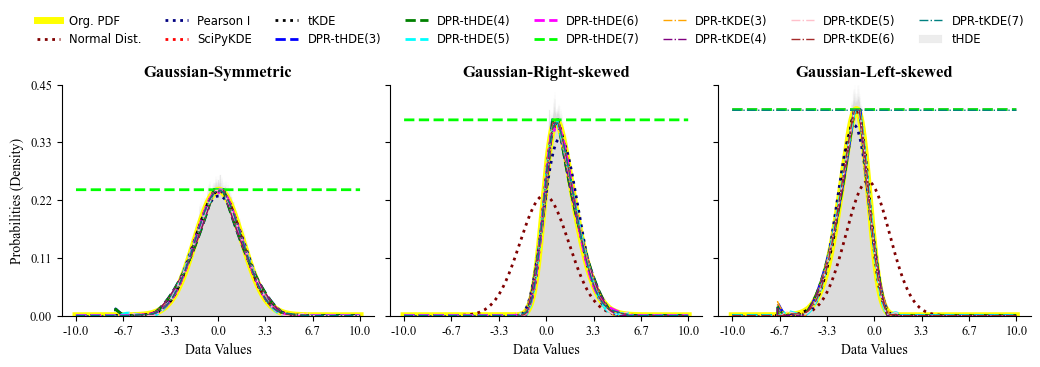

,Distribution,Function,Training,Inference,AUC,JS-Divergence,MSE,Correlation
0,Gaussian-Symmetric,tHDE,NaN,228.307247,0.999995,2.541388e-02,8.594833e-04,9.665913e-01
1,Gaussian-Symmetric,Normal Dist.,NaN,28.020144,1.000000,1.088901e-08,3.258129e-17,1.000000e+00
2,Gaussian-Symmetric,Pearson 1,NaN,3.477097,1.000000,6.594580e-04,1.388988e-05,9.989916e-01
3,Gaussian-Symmetric,SciPyKDE,NaN,7422.260284,0.999990,2.537931e-02,8.154919e-04,9.691919e-01
4,Gaussian-Symmetric,tKDE,NaN,182.906866,0.999990,2.537931e-02,8.154912e-04,9.691921e-01
5,Gaussian-Symmetric,DPR-tHDE(3),8323.826075,38.447857,0.997756,3.881439e-03,3.777686e-05,9.973722e-01
6,Gaussian-Symmetric,DPR-tHDE(4),8243.349075,50.574780,0.997167,3.939013e-03,3.798821e-05,9.973651e-01
7,Gaussian-Symmetric,DPR-tHDE(5),8354.251146,50.337076,0.995513,3.602564e-03,7.093815e-06,9.994320e-01
8,Gaussian-Symmetric,DPR-tHDE(6),8413.867712,55.177927,0.998222,3.644509e-04,5.288474e-07,9.999570e-01
9,Gaussian-Symmetric,DPR-tHDE(7),8401.292086,53.800106,4.859732,2.891445e-01,4.330522e-02,9.801052e-09


In [17]:
# Use Initial 3 distributions...
Distributions=DIST_USED[:3]
# Create 1 row and 3 columns of subplots
fig, ax = plt.subplots(1, len(Distributions), figsize=(12.5, 3), sharey=True)   # 1 row, 3 columns
plt.subplots_adjust(wspace=0.05)# Adjust horizontal space'

yMax=0; # Initialize

for i in range(len(Distributions)):
    #------------------------------------------------------------ 
    rng = np.random.RandomState(SEED*i)  # Create random number generator with fixed seed
    mu = rng.uniform(muMIN, muMAX)  # random mu between -0.5 and 0.5
    V =  rng.uniform(vMIN, vMAX)
    sigma = np.sqrt(V)
    alpha = (3-2*i) * rng.uniform(aMIN, aMAX) if i else 0  # 0, +α, -α
    #------------------------------------------------------------
    print("\n********************************************************")
    print(f"Case {i+1}: {Distributions[i]}")
    print("********************************************************")
    print(f"  {GREEK_CHAR['mu']} = {mu}")
    print(f"  {GREEK_CHAR['sigma']} = sqrt({V:.3f}) = {sigma:.3f}")
    print(f"  {GREEK_CHAR['alpha']} = {alpha:.3f}\n")
    #------------------------------------------------------------
    # Get Probabilty Distribution using Mathematical Distribution Function 
    # Create Synthetic data using Inverse Transformation
    #------------------------------------------------------------
    # Baseline
    x=np.linspace(xMIN,xMAX,nPDF)
    oPDF=GaussianPDF(x, mu, sigma, alpha)
    oAUC=ComputeAUC(x, oPDF)
    # From the Probabilty Distribution - Create Samples using Inv Transform
    S=InvTransformSampling(oPDF,x, nSAMPLES, SEED) 
    if SAVE_FILES: SaveData(S, filename=Distributions[i])# Save it
    
    print(f'x:{x.shape}  PDF:{oPDF.shape} s:{S.shape} AUC: {oAUC:.2f}')
    ax[i].plot(x,oPDF,lw=5, c='yellow', label='Org. PDF')
    #------------------------------------------------------------
    # Custom HDE() Using keras Tf - Providing nBis (Not using Freedman–Diaconis rule)
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf, BinWidth = HDE(S,nBins=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))    
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'tHDE', None, msTime, auc, jsd, mse, corr)
    print(f'xHist:{X.shape} pdfHist:{pdf.shape} BinWidth:{BinWidth:.5f} ',
          f'msTime:{msTime:.2f} JSD: {jsd:.2f}  AUC: {auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
    #--------------------
    ax[i].bar( X.numpy(),           # Bin centers
               pdf.numpy(),         # PDF values (heights)
               width=BinWidth,      # Approximate bin width
               align='center',
               alpha=0.5,
               lw=0.1,
               ec='#dcdcdc',        # Very light gray edge color ec='gray',
               fc='#dcdcdc',        #'lightgray',
               label='tHDE') 
    ##-----------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime
    #------------------------------------------------------------
    # Normal Distribution Estimation
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    #mu = np.mean(x)
    # Standard deviation (population formula)
    #Sigma = np.std(x)     
    pdf = NormPDF(x, mu, sigma) # Population Mu & StdDev
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(x, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'Normal Dist.', None, msTime, auc, jsd, mse, corr)
    print(f'Norm:{x.shape} Norm pdf:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(x,pdf,lw=2, ls=':', c='maroon', label='Normal Dist.') 
    #-----------------------------------------------------------
    del pdf, auc, jsd, mse, corr, start, end, msTime
    #------------------------------------------------------------
    # Pearson Distribution 
    #------------------------------------------------------------
    ResetBackEnd()
    Type=GetPearsonType(oPDF)
    if Type > 1:
        print(f"Probability distribution Type > 1. It is Type {Type}.")
        #input("Press Enter to continue...")
    else: 
        print(f"*** Pearson PDF Type: {Type} ***")
        start=time.time();
        if Type: #The Pearson‐I distribution can also be described as the beta‐I distribution
            # Evaluate PDF - Pearson‐I distribution 
            pdf = Pearson_I_PDF(S,x)
        else: #Pearson‐0 distribution = normal distribution 
            pdf = NormPDF(x, mu, sigma) # Population Mu & StdDev
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 

        if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
        auc=ComputeAUC(x, pdf)
        jsd=ComputeJSD(oPDF,pdf)
        mse=tf.reduce_mean(tf.square(oPDF - pdf))
        corr=ComputePearsonCorr(oPDF, pdf)
        df = UpdateDf(df, Distributions[i], 'Pearson %d'%Type, None, msTime, auc, jsd, mse, corr)
        print(f'Norm:{x.shape} Norm pdf:{pdf.shape}  msTime:{msTime:.2f} ',
              f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
        ax[i].plot(x,pdf,lw=2, ls=':', c='navy', label='Pearson I') 
    #-----------------------------------------------------
    del pdf, auc, jsd, mse, corr, start, end, msTime     
    #------------------------------------------------------------
    # SciPyKDE()
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf = SciPyKDE(S,Points=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds    
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'SciPyKDE', None, msTime, auc, jsd, mse, corr)
    print(f'xSciPyKDE:{X.shape} SciPyKDE:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(X,pdf,lw=2, ls=':', c='r', label='SciPyKDE') 
    #-----------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime
    #------------------------------------------------------------
    # Custom KDE() Using keras Tf 
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf = KDE(S,Points=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))  
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'tKDE', None, msTime, auc, jsd, mse,corr)
    print(f'xKDE:{X.shape} pdfKDE:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(X,pdf,lw=2, ls=':', c='k', label='tKDE')
    #------------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime    
    #***********************************************************
    # Here onwards will be using DualPolyRegPDF
    #***********************************************************
    for UseKDE in [False, True]:
        print("\n************************************************")
        if UseKDE: 
            print("Within DualPolyRegPDF() - using KDE()");
            ls='-.'; lw=1;
            ColorList=POLY_ORDER_COLORS[len(POLY_ORDERS):]
            FuncLabel='DPR-tKDE'
        else:      
            print("Within DualPolyRegPDF() - using HDE()") 
            ls='--'; lw=2;
            ColorList=POLY_ORDER_COLORS[:len(POLY_ORDERS)+1]
            FuncLabel='DPR-tHDE'
        print("************************************************")
        #-------------------------------------------------------
        # Dummy Call - to fix the timing calculation   
        #--------------------------------------------------------
        ResetBackEnd()
        start = time.time()
        F=DualPolyRegPDF(S, Points=nPDF, PolyOrder=3, TimesStd=PROB_FUNC_TH, UseKDE=UseKDE)
        end = time.time()
        msTrain = (end - start) * 1000  # Convert to milliseconds     
        
        ResetBackEnd()
        start = time.time()
        pdf=F(x) # MemFunc
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 
        print(f'pdfFunc:{pdf.shape}  msTrain:{msTrain:.2f} msTime:{msTime:.2f}')
        #--------------------------------------------------------
        del pdf, start, end, msTime, msTrain
        #========================================================
        for Order, Color in zip(POLY_ORDERS, ColorList):
            #----------------------------------------------------
            # Training
            #----------------------------------------------------
            ResetBackEnd()
            start = time.time()
            F=DualPolyRegPDF(S, Points=nPDF, PolyOrder=Order, TimesStd=PROB_FUNC_TH, UseKDE=UseKDE)
            end = time.time()
            msTrain = (end - start) * 1000  # Convert to milliseconds   
            #----------------------------------------------------
            del start, end
            #----------------------------------------------------
            # Inference
            ResetBackEnd()
            start = time.time()
            pdf=F(x)
            end = time.time()
            msTime = (end - start) * 1000  # Convert to milliseconds 
            print(f'Order#{Order} - pdfFunc:{pdf.shape} msTrain:{msTrain:.2f} msTime:{msTime:.2f}')
    
            if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
            auc=ComputeAUC(x, pdf)
            jsd=ComputeJSD(oPDF,pdf)
            mse=tf.reduce_mean(tf.square(oPDF - pdf))
            corr=ComputePearsonCorr(oPDF, pdf)
            df = UpdateDf(df, Distributions[i],'%s(%d)'%(FuncLabel,Order), msTrain, msTime, auc, jsd, mse,corr)  
            print(f'pdfFunc:{pdf.shape}   msTrain:{msTrain:.2f} msTime:{msTime:.2f} ',
                  f'JSD:{jsd:.2f} AUC:{auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
            ax[i].plot(x,pdf,lw=lw, ls=ls, c=Color, label='%s(%d)'%(FuncLabel,Order));
            #----------------------------------------------------  
            del pdf, start, end, msTime, msTrain, auc, jsd, mse, corr
    #------------------------------------------------------------    
    # Set x Axis, Hide Spines , Set Title
    xTicks = np.linspace(xMIN, xMAX, 7)
    ax[i].set_xticks(xTicks)
    ax[i].set_xticklabels(['%.1f' % x for x in xTicks], fontdict=FontNorm9)
    ax[i].set_xlabel("Data Values", fontdict=FontNorm10)
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].set_title(Distributions[i], fontdict=SubTitleFont)    
    #------------------------------------------------------------
#********************************************************
# Set y Axis,
ax[0].set_ylim(0, yMax)
yTicks = np.linspace(0, yMax, 5)
ax[0].set_yticks(yTicks)
ax[0].set_yticklabels(['%.2f' % y for y in yTicks], fontdict=FontNorm9)
ax[0].set_ylabel("Probabilities (Density)", fontdict=FontNorm10)

# Set Legend - Get handles and labels from only the last subplot
handles, labels = ax[0].get_legend_handles_labels()
# Find the index of 'HDE' in labels
hde_index = labels.index('tHDE')
# Update the color of the corresponding handle
if isinstance(handles[hde_index], Line2D): handles[hde_index].set_color('gray')
# Create a common legend using these handles/labels
fig.legend(handles, labels,loc='upper center',ncol=8,fontsize='small',frameon=False,bbox_to_anchor=(0.5, 1.15))
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig3.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig3.pdf", 
                bbox_inches="tight")

plt.show()
#------------------------------------------------------------
# Display Dataframe
display(df)
   

In [18]:
# Example: remove rows where Distribution starts with 'Asymmetric'
#df = df[~df['Distribution'].str.startswith('Asymmetric')]
#df["Distribution"].unique()


## Comparison of Probability Density Estimation Methods on Asymmetric Distributions

This code evaluates and compares multiple probability density estimation techniques applied to three asymmetric distributions: two variants of the Asymmetric M-Wright distribution and the Asymmetric Laplace distribution. For each distribution, synthetic samples are generated and various estimation methods are applied, including Histogram Density Estimation (HDE), Normal distribution fitting, Pearson Type I distribution, SciPy KDE, TensorFlow-based KDE, and Dual Polynomial Regression PDFs with and without KDE. Key performance metrics such as Jensen-Shannon Divergence, AUC, MSE, and Pearson correlation are computed to assess estimator accuracy and computational efficiency. Results are visualized side-by-side to provide insights into the suitability of each method for modeling asymmetric data.


********************************************************
Case 1: Asymmetric-M-Wright-I
********************************************************
ν = 0.260 λ = 1.715
Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-M-Wright-I.npy
x:(10000,)  PS:(200000,) DF:(10000,) AUC: 1.00


2025-10-02 13:34:52.470258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00133  msTime:110.47 JSD: 0.49  AUC: 1.00 MSE:0.032 Corr:-0.098
Norm:(10000,) Norm pdf:(10000,)  msTime:79.11  JSD:0.02 AUC:1.00, MSE:0.001 Corr:0.941

************************************************************
Mu:0.050 Central Moments 2:0.012 3:0.003  4:0.001
Pearson constants β1: 6.662, β2: 8.80 κ: -4.155  γ1:2.581 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:3.87  JSD:0.01 AUC:1.00, MSE:0.001 Corr:0.952
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:6941.61  JSD:0.49 AUC:1.00, MSE:0.032 Corr:-0.098


2025-10-02 13:35:11.782283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:177.96  JSD:0.49 AUC:1.00 MSE:0.032 Corr:-0.098

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:35:15.106691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:35:25.700830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8762.38 msTime:59.72


2025-10-02 13:35:27.822833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:35:38.361330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8733.77 msTime:54.20
pdfFunc:(10000,)   msTrain:8733.77 msTime:54.20  JSD:0.02 AUC:0.97 MSE:0.000 Corr:0.983


2025-10-02 13:35:40.757871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:35:51.342080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8767.02 msTime:60.40
pdfFunc:(10000,)   msTrain:8767.02 msTime:60.40  JSD:0.02 AUC:0.97 MSE:0.000 Corr:0.993


2025-10-02 13:35:53.755995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:04.330024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8763.37 msTime:54.66
pdfFunc:(10000,)   msTrain:8763.37 msTime:54.66  JSD:0.02 AUC:0.97 MSE:0.000 Corr:0.996


2025-10-02 13:36:06.714003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:17.303849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8773.24 msTime:54.32
pdfFunc:(10000,)   msTrain:8773.24 msTime:54.32  JSD:0.01 AUC:0.96 MSE:0.000 Corr:0.997


2025-10-02 13:36:19.692080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:30.271432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8761.22 msTime:53.85
pdfFunc:(10000,)   msTrain:8761.22 msTime:53.85  JSD:0.02 AUC:0.96 MSE:0.000 Corr:0.992

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:36:32.677470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:36.493059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:1979.66 msTime:54.60


2025-10-02 13:36:38.624341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:42.009371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:1562.62 msTime:58.27
pdfFunc:(10000,)   msTrain:1562.62 msTime:58.27  JSD:0.02 AUC:0.99 MSE:0.001 Corr:0.981


2025-10-02 13:36:44.416182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:47.815975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1529.47 msTime:58.50
pdfFunc:(10000,)   msTrain:1529.47 msTime:58.50  JSD:0.01 AUC:1.00 MSE:0.000 Corr:0.995


2025-10-02 13:36:50.214285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:53.616046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1567.00 msTime:54.95
pdfFunc:(10000,)   msTrain:1567.00 msTime:54.95  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.997


2025-10-02 13:36:56.017249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:36:59.405405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1556.12 msTime:65.87
pdfFunc:(10000,)   msTrain:1556.12 msTime:65.87  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:37:01.830656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:37:02.644285: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:37:05.253938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:1610.04 msTime:54.39
pdfFunc:(10000,)   msTrain:1610.04 msTime:54.39  JSD:0.37 AUC:9.46 MSE:0.191 Corr:0.000

********************************************************
Case 2: Asymmetric-M-Wright-II
********************************************************
ν = 0.225  α= 1.951
Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-M-Wright-II.npy
x:(10000,)  PS:(200000,) DF:(10000,) AUC: 1.00


2025-10-02 13:37:08.532783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00147  msTime:106.99 JSD: 0.29  AUC: 1.00 MSE:0.013 Corr:0.099
Norm:(10000,) Norm pdf:(10000,)  msTime:99.19  JSD:0.03 AUC:1.00, MSE:0.001 Corr:0.885

************************************************************
Mu:0.050 Central Moments 2:0.006 3:0.001  4:0.000
Pearson constants β1: 3.572, β2: 5.70 κ: -2.693  γ1:1.890 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:3.16  JSD:0.03 AUC:1.00, MSE:0.001 Corr:0.886
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:7625.24  JSD:0.28 AUC:1.00, MSE:0.013 Corr:0.102


2025-10-02 13:37:27.984566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:182.88  JSD:0.28 AUC:1.00 MSE:0.013 Corr:0.102

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:37:31.488501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:37:42.220870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8805.44 msTime:68.03


2025-10-02 13:37:44.458064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:37:55.098613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8733.21 msTime:67.97
pdfFunc:(10000,)   msTrain:8733.21 msTime:67.97  JSD:0.01 AUC:0.99 MSE:0.000 Corr:0.986


2025-10-02 13:37:57.619018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:38:08.301194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8783.18 msTime:55.97
pdfFunc:(10000,)   msTrain:8783.18 msTime:55.97  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.999


2025-10-02 13:38:10.840141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:38:21.580717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8838.36 msTime:56.04
pdfFunc:(10000,)   msTrain:8838.36 msTime:56.04  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:38:24.113218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:38:34.870174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8849.52 msTime:58.50
pdfFunc:(10000,)   msTrain:8849.52 msTime:58.50  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:38:37.397587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:38:48.150440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8809.55 msTime:62.70
pdfFunc:(10000,)   msTrain:8809.55 msTime:62.70  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:38:50.695022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:38:54.192095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:1564.27 msTime:57.63


2025-10-02 13:38:56.449801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:39:00.089822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:1569.89 msTime:75.58
pdfFunc:(10000,)   msTrain:1569.89 msTime:75.58  JSD:0.01 AUC:0.99 MSE:0.000 Corr:0.985


2025-10-02 13:39:02.916672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:39:06.750126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1743.36 msTime:63.95
pdfFunc:(10000,)   msTrain:1743.36 msTime:63.95  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.998


2025-10-02 13:39:09.519546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:39:13.280842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1708.88 msTime:76.76
pdfFunc:(10000,)   msTrain:1708.88 msTime:76.76  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:39:16.149322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:39:20.208840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1750.05 msTime:78.81
pdfFunc:(10000,)   msTrain:1750.05 msTime:78.81  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:39:23.165634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:39:24.016902: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:39:27.170243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:1768.03 msTime:77.86
pdfFunc:(10000,)   msTrain:1768.03 msTime:77.86  JSD:0.27 AUC:6.26 MSE:0.076 Corr:nan

********************************************************
Case 3: Asymmetric-Laplace
********************************************************
m = -0.454 λ= 1.370  κ= 1.345
Saved /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-Laplace.npy
x:(10000,)  PS:(200000,) DF:(10000,) AUC: 1.00


2025-10-02 13:39:31.348410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xHist:(10000,) pdfHist:(10000,) BinWidth:0.00174  msTime:122.99 JSD: 0.54  AUC: 1.00 MSE:0.033 Corr:-0.117
Norm:(10000,) Norm pdf:(10000,)  msTime:109.10  JSD:0.02 AUC:1.00, MSE:0.002 Corr:0.927

************************************************************
Mu:0.050 Central Moments 2:0.014 3:0.005  4:0.002
Pearson constants β1: 9.170, β2: 12.00 κ: -4.738  γ1:3.028 
Type I (Beta distribution on a finite interval, skewed; bounded both sides.)
*** Pearson PDF Type: 1 ***
Norm:(10000,) Norm pdf:(10000,)  msTime:3.93  JSD:0.02 AUC:1.00, MSE:0.002 Corr:0.932
xSciPyKDE:(10000,) SciPyKDE:(10000,)  msTime:6713.40  JSD:0.54 AUC:1.00, MSE:0.033 Corr:-0.117


2025-10-02 13:39:51.956153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


xKDE:(10000,) pdfKDE:(10000,)  msTime:59.65  JSD:0.54 AUC:1.00 MSE:0.033 Corr:-0.117

************************************************
Within DualPolyRegPDF() - using HDE()
************************************************


2025-10-02 13:39:55.394600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:40:06.357181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:8735.33 msTime:63.81


2025-10-02 13:40:08.992218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:40:19.867071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:8654.09 msTime:68.91
pdfFunc:(10000,)   msTrain:8654.09 msTime:68.91  JSD:0.03 AUC:0.98 MSE:0.001 Corr:0.966


2025-10-02 13:40:22.811733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:40:33.931436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:8848.12 msTime:75.95
pdfFunc:(10000,)   msTrain:8848.12 msTime:75.95  JSD:0.01 AUC:0.98 MSE:0.000 Corr:0.994


2025-10-02 13:40:36.709372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:40:47.653203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:8769.20 msTime:63.73
pdfFunc:(10000,)   msTrain:8769.20 msTime:63.73  JSD:0.00 AUC:0.99 MSE:0.000 Corr:0.999


2025-10-02 13:40:50.646848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:01.637510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:8873.84 msTime:66.29
pdfFunc:(10000,)   msTrain:8873.84 msTime:66.29  JSD:0.00 AUC:1.00 MSE:0.000 Corr:1.000


2025-10-02 13:41:04.528994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:12.540671: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:41:15.628470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:8924.02 msTime:64.63
pdfFunc:(10000,)   msTrain:8924.02 msTime:64.63  JSD:0.37 AUC:12.69 MSE:0.355 Corr:nan

************************************************
Within DualPolyRegPDF() - using KDE()
************************************************


2025-10-02 13:41:18.533019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:23.858648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


pdfFunc:(10000,)  msTrain:3251.41 msTime:78.11


2025-10-02 13:41:26.269883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:29.971787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#3 - pdfFunc:(10000,) msTrain:1708.09 msTime:61.74
pdfFunc:(10000,)   msTrain:1708.09 msTime:61.74  JSD:0.03 AUC:0.98 MSE:0.001 Corr:0.964


2025-10-02 13:41:32.667351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:36.345355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#4 - pdfFunc:(10000,) msTrain:1663.91 msTime:65.23
pdfFunc:(10000,)   msTrain:1663.91 msTime:65.23  JSD:0.01 AUC:0.98 MSE:0.000 Corr:0.993


2025-10-02 13:41:39.023423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:42.693520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#5 - pdfFunc:(10000,) msTrain:1671.05 msTime:62.19
pdfFunc:(10000,)   msTrain:1671.05 msTime:62.19  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:41:45.387763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:49.252937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#6 - pdfFunc:(10000,) msTrain:1868.76 msTime:69.29
pdfFunc:(10000,)   msTrain:1868.76 msTime:69.29  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999


2025-10-02 13:41:52.164426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:41:56.153030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order#7 - pdfFunc:(10000,) msTrain:2027.12 msTime:72.64
pdfFunc:(10000,)   msTrain:2027.12 msTime:72.64  JSD:0.00 AUC:1.00 MSE:0.000 Corr:0.999
Updated yMax: 0.634


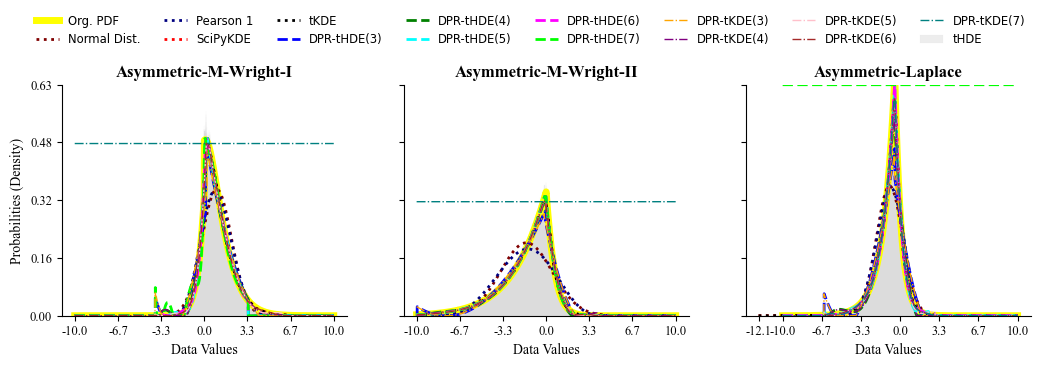

,Distribution,Function,Training,Inference,AUC,JS-Divergence,MSE,Correlation
0,Gaussian-Symmetric,tHDE,NaN,228.307247,0.999995,2.541388e-02,8.594833e-04,0.966591
1,Gaussian-Symmetric,Normal Dist.,NaN,28.020144,1.000000,1.088901e-08,3.258129e-17,1.000000
2,Gaussian-Symmetric,Pearson 1,NaN,3.477097,1.000000,6.594580e-04,1.388988e-05,0.998992
3,Gaussian-Symmetric,SciPyKDE,NaN,7422.260284,0.999990,2.537931e-02,8.154919e-04,0.969192
4,Gaussian-Symmetric,tKDE,NaN,182.906866,0.999990,2.537931e-02,8.154912e-04,0.969192
...,...,...,...,...,...,...,...,...
85,Asymmetric-Laplace,DPR-tKDE(3),1708.090067,61.744928,0.975912,2.617544e-02,1.167755e-03,0.963886
86,Asymmetric-Laplace,DPR-tKDE(4),1663.908243,65.231800,0.978796,8.977038e-03,2.005392e-04,0.993449
87,Asymmetric-Laplace,DPR-tKDE(5),1671.048403,62.190771,0.995798,3.094633e-03,3.591323e-05,0.998773
88,Asymmetric-Laplace,DPR-tKDE(6),1868.759871,69.294214,0.999157,1.146386e-03,1.645772e-05,0.999437


In [19]:
Distributions=DIST_USED[3:] # 3 Distributions Type from End
PDF_Func_List = [Create_AWM_I_PDF, Create_AWM_II_PDF, AsymLaplacePDF]

# Create 1 row and 3 columns of subplots
fig, ax = plt.subplots(1, len(PDF_Func_List), figsize=(12.5, 3), sharey=True)   # 1 row, 3 columns

yMax=0; # Initialize

for i in range(len(PDF_Func_List)):
    #------------------------------------------------------------    
    x=np.linspace(xMIN,xMAX,nPDF)
    J=int(100)
    print("\n********************************************************")
    print(f"Case {i+1}: {Distributions[i]}")
    print("********************************************************")
    # Get Probabilty Distribution using Mathematical Distribution Function 
    #------------------------------------------------------------
    rng = np.random.RandomState(SEED*i)  # Create random number generator with fixed seed
    if i==0:
        v = rng.uniform(nuMIN, nuMAX) # Shape 0.15 - 0.35
        lamda=rng.uniform(lMIN, lMAX) # Skewness Param: 1- 2
        print(f"{GREEK_CHAR['nu']} = {v:.3f} {GREEK_CHAR['lamda']} = {lamda:.3f}")
        oPDF=Create_AWM_I_PDF(x, v, lamda,int(J))
    elif i==1:
        v = rng.uniform(nuMIN, nuMAX)   # Shape 0.15 - 0.35
        alpha=rng.uniform(lMIN, lMAX)   # Skewness Param: 1- 2
        print(f"{GREEK_CHAR['nu']} = {v:.3f}  {GREEK_CHAR['alpha']}= {alpha:.3f}")
        oPDF=Create_AWM_II_PDF(x, v, alpha, int(J))
    else:    
        m = rng.uniform(muMIN, muMAX)      # location: -0.5 +0.5
        lamda = rng.uniform(lMIN, lMAX)    # scale 1- 2
        kappa = rng.uniform(kMIN, kMAX)    # asymmetry 1.2 - 1.8        
        print(f"m = {m:.3f} {GREEK_CHAR['lamda']}= {lamda:.3f}  {GREEK_CHAR['kappa']}= {kappa:.3f}")
        oPDF=AsymLaplacePDF(x, m, lamda,kappa)
    #------------------------------------------------------------
    oAUC=ComputeAUC(x, oPDF)
    # From the Probabilty Distribution - Create Samples using Inv Transform
    if i<2: S= InvTransformSampling(oPDF,x, nSAMPLES, SEED) 
    else:   S= SampleAsymLaplace(m, lamda, kappa, nSAMPLES, SEED) 
    
    if SAVE_FILES: SaveData(S, filename=Distributions[i])# Save it
    
    print(f'x:{x.shape}  PS:{S.shape} DF:{oPDF.shape} AUC: {oAUC:.2f}')
    ax[i].plot(x,oPDF,lw= 5, c='yellow', label='Org. PDF')

    #------------------------------------------------------------
    # Custom HDE() Using keras Tf - Providing nBis (Not using Freedman–Diaconis rule)
    #------------------------------------------------------------
    #del X, pdf, auc, jsd, start, end, msTime
    ResetBackEnd()
    start = time.time()
    X, pdf, BinWidth = HDE(S,nBins=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds    
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'tHDE', None, msTime, auc, jsd, mse, corr)
    print(f'xHist:{X.shape} pdfHist:{pdf.shape} BinWidth:{BinWidth:.5f} ',
          f'msTime:{msTime:.2f} JSD: {jsd:.2f}  AUC: {auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
    #--------------------
    ax[i].bar( X.numpy(),           # Bin centers
               pdf.numpy(),         # PDF values (heights)
               width=BinWidth,      # Approximate bin width
               align='center',
               alpha=0.5,
               lw=0.1,
               ec='#dcdcdc',        # Very light gray edge color ec='gray',
               fc='#dcdcdc',        #'lightgray',
               label='tHDE')     
    ##-----------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime
    
    #------------------------------------------------------------
    # Normal Distribution Estimation
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()   
    pdf = NormPDF(x, np.mean(S), np.std(S)) # Population Mu & StdDev
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(x, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'Normal Dist.', None, msTime, auc, jsd, mse, corr)
    print(f'Norm:{x.shape} Norm pdf:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(x,pdf,lw=2, ls=':', c='maroon', label='Normal Dist.') 
    #-----------------------------------------------------------
    del pdf, auc, jsd, mse, corr, start, end, msTime
    #------------------------------------------------------------
    # Pearson Dist
    #------------------------------------------------------------
    ResetBackEnd()
    Type=GetPearsonType(oPDF)
    if Type > 1:
        print(f"Probability distribution Type > 1. It is Type {Type}.")
        start=time.time();
        if Type==4:
            pdf = Pearson_IV_PDF(S,x)
        elif Type==6:
            pdf = Pearson_VI_PDF(S,x)
        else: 
            print(f"Func Not there = Probability distribution Type {Type}.")
            pdf = None 
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 
    else: 
        print(f"*** Pearson PDF Type: {Type} ***")
        start=time.time();
        if Type: #The Pearson‐I distribution can also be described as the beta‐I distribution
            # Evaluate PDF - Pearson‐I distribution 
            pdf = Pearson_I_PDF(S,x)
        else: #Pearson‐0 distribution = normal distribution 
            pdf = NormPDF(x, mu, sigma) # Population Mu & StdDev
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 
    #-----------------------------------------------------    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(x, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'Pearson %d'%Type, None, msTime, auc, jsd, mse, corr)
    print(f'Norm:{x.shape} Norm pdf:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(x,pdf,lw=2, ls=':', c='navy', label='Pearson %d'%Type) 
    #-----------------------------------------------------
    del pdf, auc, jsd, mse, corr, start, end, msTime         
    #------------------------------------------------------------
    # SciPyKDE()
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf = SciPyKDE(S,Points=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds    
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'SciPyKDE', None, msTime, auc, jsd, mse, corr)
    print(f'xSciPyKDE:{X.shape} SciPyKDE:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(X,pdf,lw=2, ls=':', c='r', label='SciPyKDE') 
    #-----------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime
    #------------------------------------------------------------
    # Custom KDE() Using keras Tf 
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf = KDE(S,Points=nPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed       
    auc=ComputeAUC(X, pdf)
    jsd=ComputeJSD(oPDF,pdf)
    mse=tf.reduce_mean(tf.square(oPDF - pdf))  
    corr=ComputePearsonCorr(oPDF, pdf)
    df = UpdateDf(df, Distributions[i], 'tKDE', None, msTime, auc, jsd, mse, corr)
    print(f'xKDE:{X.shape} pdfKDE:{pdf.shape}  msTime:{msTime:.2f} ',
          f'JSD:{jsd:.2f} AUC:{auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
    ax[i].plot(X,pdf,lw=2, ls=':', c='k', label='tKDE')
    #------------------------------------------------------------
    del X, pdf, auc, jsd, mse, corr, start, end, msTime    
    #***********************************************************
    # Here onwards will be using DualPolyRegPDF
    #***********************************************************    
    for UseKDE in [False, True]:
        print("\n************************************************")
        if UseKDE: 
            print("Within DualPolyRegPDF() - using KDE()");
            ls='-.'; lw=1;
            ColorList=POLY_ORDER_COLORS[len(POLY_ORDERS):]
            FuncLabel='DPR-tKDE'
        else:      
            print("Within DualPolyRegPDF() - using HDE()") 
            ls='--'; lw=2;
            ColorList=POLY_ORDER_COLORS[:len(POLY_ORDERS)+1]
            FuncLabel='DPR-tHDE'
        print("************************************************")
        #-------------------------------------------------------
        # Dummy Call - to fix the timing calculation   
        #--------------------------------------------------------
        ResetBackEnd()
        start = time.time()
        F=DualPolyRegPDF(S, Points=nPDF, PolyOrder=3, TimesStd=PROB_FUNC_TH, UseKDE=UseKDE)
        end = time.time()
        msTrain = (end - start) * 1000  # Convert to milliseconds     
        
        ResetBackEnd()
        start = time.time()
        pdf=F(x) # MemFunc
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 
        print(f'pdfFunc:{pdf.shape}  msTrain:{msTrain:.2f} msTime:{msTime:.2f}')
        #--------------------------------------------------------
        del pdf, start, end, msTime, msTrain
        #========================================================
        for Order, Color in zip(POLY_ORDERS, ColorList):
            #----------------------------------------------------
            # Training
            #----------------------------------------------------
            ResetBackEnd()
            start = time.time()
            F=DualPolyRegPDF(S, Points=nPDF, PolyOrder=Order, TimesStd=PROB_FUNC_TH, UseKDE=UseKDE)
            end = time.time()
            msTrain = (end - start) * 1000  # Convert to milliseconds   
            #----------------------------------------------------
            del start, end
            #----------------------------------------------------
            # Inference
            #----------------------------------------------------
            ResetBackEnd()
            start = time.time()
            pdf=F(x)
            end = time.time()
            msTime = (end - start) * 1000  # Convert to milliseconds 
            print(f'Order#{Order} - pdfFunc:{pdf.shape} msTrain:{msTrain:.2f} msTime:{msTime:.2f}')
    
            if yMax < np.amax(pdf) and not np.isnan(np.amax(pdf)): yMax=np.amax(pdf); #  Update if needed
            auc=ComputeAUC(x, pdf)
            jsd=ComputeJSD(oPDF,pdf)
            mse=tf.reduce_mean(tf.square(oPDF - pdf))
            corr=ComputePearsonCorr(oPDF, pdf)
            df = UpdateDf(df, Distributions[i],'%s(%d)'%(FuncLabel,Order), msTrain, msTime, auc, jsd,mse,corr)  
            print(f'pdfFunc:{pdf.shape}   msTrain:{msTrain:.2f} msTime:{msTime:.2f} ',
                  f'JSD:{jsd:.2f} AUC:{auc:.2f} MSE:{mse:.3f} Corr:{corr:.3f}')
            ax[i].plot(x,pdf,lw=lw, ls=ls, c=Color, label='%s(%d)'%(FuncLabel,Order));
            #----------------------------------------------------  
            del pdf, start, end, msTime, msTrain, auc, jsd, mse, corr
    #------------------------------------------------------------    
    # Set x Axis, Hide Spines , Set Title
    xTicks = np.linspace(xMIN, xMAX, 7)
    if  np.amin(S)< xMIN: xTicks = np.concatenate(([np.amin(S)], xTicks))
    if  np.amax(S)> xMAX: xTicks = np.concatenate((xTicks, [np.amax(S)]))    
    ax[i].set_xticks(xTicks)
    ax[i].set_xticklabels(['%.1f' % x for x in xTicks], fontdict=FontNorm9)
    ax[i].set_xlabel("Data Values", fontdict=FontNorm10)
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].set_title(Distributions[i], fontdict=SubTitleFont)    
    #break
    #------------------------------------------------------------
#********************************************************
# Set y Axis,
if yMax>1: yMax=1
print(f'Updated yMax: {yMax:.3f}'); 
ax[0].set_ylim(0, yMax)
yTicks = np.linspace(0, yMax, 5)
ax[0].set_yticks(yTicks)
ax[0].set_yticklabels(['%.2f' % y for y in yTicks], fontdict=FontNorm9)
ax[0].set_ylabel("Probabilities (Density)", fontdict=FontNorm10)

# Set Legend - Get handles and labels from only the last subplot
handles, labels = ax[0].get_legend_handles_labels()
# Find the index of 'HDE' in labels
hde_index = labels.index('tHDE')
# Update the color of the corresponding handle
if isinstance(handles[hde_index], Line2D): handles[hde_index].set_color('gray')
# Create a common legend using these handles/labels
fig.legend(handles, labels,loc='upper center',ncol=8,fontsize='small',frameon=False,bbox_to_anchor=(0.5, 1.15))
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig4.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig4.pdf", 
                bbox_inches="tight")
plt.show()
#------------------------------------------------------------
# Display Dataframe
display(df) 
#Save as csv File
if SAVE_FILES: df.to_csv(METRICS_PATH+"/SyntheticDataMetrics.csv", index=False)



## Plot Metrics across Functions for each Distribution

**Metrics** = ['Inference', 'AUC', 'JS-Divergence', 'MSE', 'Correlation']

xTickLabels: 15: ['tHDE' 'Normal Dist.' 'Pearson 1' 'SciPyKDE' 'tKDE' 'DPR-tHDE(3)'
 'DPR-tHDE(4)' 'DPR-tHDE(5)' 'DPR-tHDE(6)' 'DPR-tHDE(7)' 'DPR-tKDE(3)'
 'DPR-tKDE(4)' 'DPR-tKDE(5)' 'DPR-tKDE(6)' 'DPR-tKDE(7)']
Labels: 6: ['Gaussian-Symmetric' 'Gaussian-Right-skewed' 'Gaussian-Left-skewed'
 'Asymmetric-M-Wright-I' 'Asymmetric-M-Wright-II' 'Asymmetric-Laplace']
#1 - Inference
Gaussian-Symmetric
Gaussian-Right-skewed
Gaussian-Left-skewed
Asymmetric-M-Wright-I
Asymmetric-M-Wright-II
Asymmetric-Laplace
Mean:  [1.247230e+02 7.469100e+01 3.519000e+00 7.298205e+03 1.398790e+02
 5.314800e+01 5.508300e+01 5.220600e+01 5.453300e+01 5.459800e+01
 5.429600e+01 5.386100e+01 5.760600e+01 6.675700e+01 5.685900e+01]
SortIndices: [ 2  7  5 11 10  8  9  6 14 12 13  1  0  4  3]
RankingWts[0,:] : [ 3  4 15  1  2 13  8 14 10  9 11 12  6  5  7]
#2 - AUC
Gaussian-Symmetric
Gaussian-Right-skewed
Gaussian-Left-skewed
Asymmetric-M-Wright-I
Asymmetric-M-Wright-II
Asymmetric-Laplace
Mean:  [0.000e+00 0.000e+00 

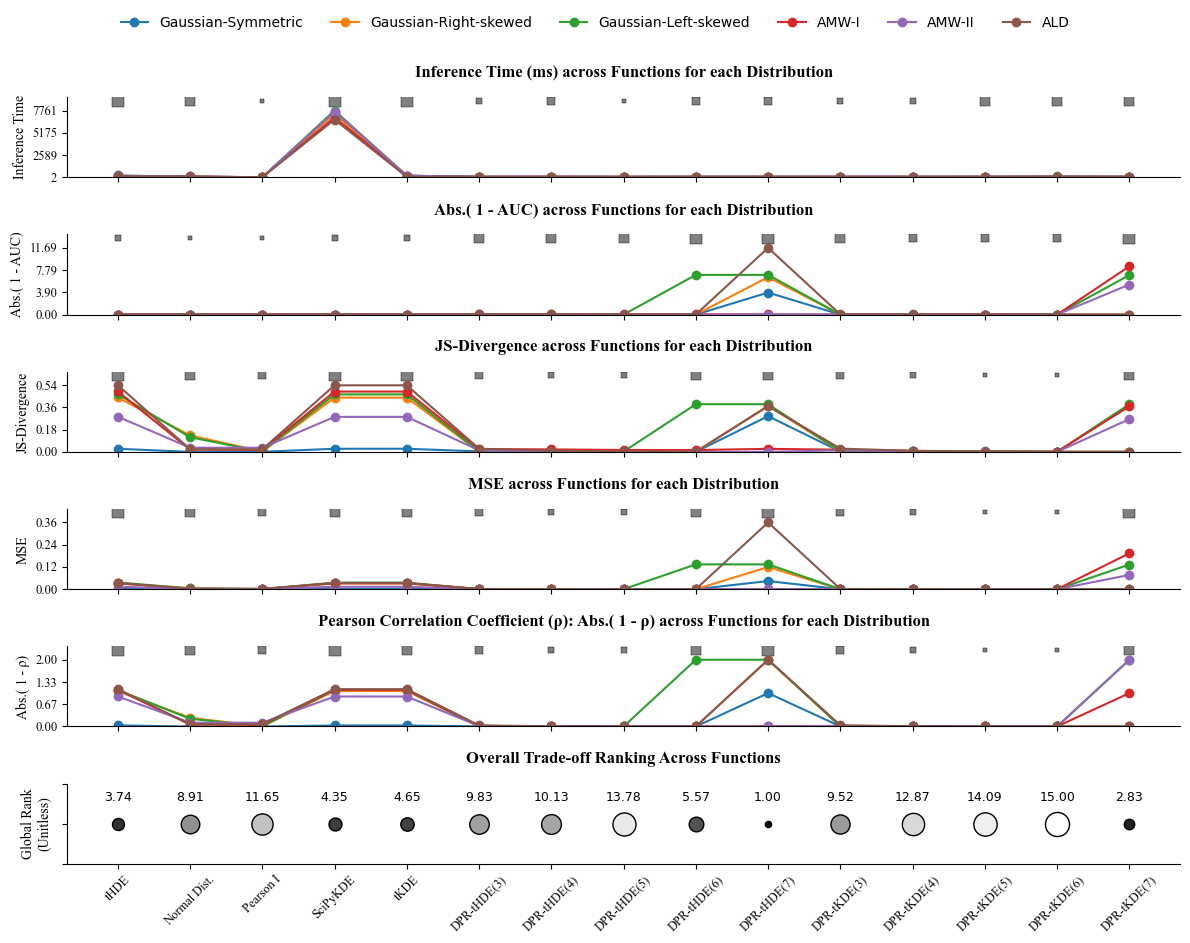

In [20]:
xTickLabels = df["Function"].unique()
# Set Manually 
xTickLabelsP = ['tHDE', 'Normal Dist.', 'Pearson I', 'SciPyKDE', 'tKDE', 
                'DPR-tHDE(3)','DPR-tHDE(4)','DPR-tHDE(5)','DPR-tHDE(6)','DPR-tHDE(7)',
                'DPR-tKDE(3)','DPR-tKDE(4)','DPR-tKDE(5)','DPR-tKDE(6)','DPR-tKDE(7)'];

print(f'xTickLabels: {xTickLabels.size}: {xTickLabels}') #

DistLabels= df['Distribution'].unique()
print(f'Labels: {DistLabels.size}: {DistLabels}')
# Metrics to plot
Metrics = ['Inference', 'AUC', 'JS-Divergence', 'MSE', 'Correlation']
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(12, 9), sharex=True)  # 5 rows
# Adjust vertical spacing
fig.subplots_adjust(hspace=0.2)  # Increase or decrease spacing
RankingWts=np.zeros((5,15), dtype=int)
# Plot each metric
for i, metric in enumerate(Metrics):
    print(f"#{i+1} - {metric}")
    Arr=np.zeros((DistLabels.size, xTickLabels.size))
    for j, DistLabel in enumerate(DistLabels):
        print(DistLabel)
        subset = df[df['Distribution'] == DistLabel]
        # Convert to numpy arrays
        xLabels = subset['Function'].values
        y = subset[metric].values
        
        # Sort according to xTickLabels order - To make sure the ref wrt x Axis
        SortIdx = np.argsort([np.where(xTickLabels == x)[0][0] for x in xLabels])
        xLabels = xLabels[SortIdx]
        y = y[SortIdx]
        y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
        y = np.where(np.isnan(y), -1, y)
        if metric=='AUC' or metric=='Correlation': y=np.abs(1-y)
        #print(f'AUC: {np.amin(y)}   {np.amax(y)}')
        #print(f'Correlation: {np.amin(y)}   {np.amax(y)}')
        
        if DistLabel== 'Asymmetric-M-Wright-I': Label='AMW-I'
        elif DistLabel== 'Asymmetric-M-Wright-II': Label='AMW-II'
        elif DistLabel== 'Asymmetric-Laplace': Label='ALD'  
        else: Label= DistLabel
            
        Arr[j,:]=y
        axs[i].plot(np.arange(y.size), y, marker='o', label=Label)
    
    #----------------------------------------------------------------------------- 
    # --- Plot squares above the plot to show increase/decrease in mean
    #----------------------------------------------------------------------------- 
    MeanVal=np.mean(Arr, axis=0)
    print("Mean: ", np.round(MeanVal,3))
    SortIndices = np.argsort(MeanVal)
    print(f'SortIndices: {SortIndices}')
    y_pos_squares = np.amax(Arr) * 1.15
    for rank, idx in enumerate(SortIndices):
        axs[i].scatter(idx, y_pos_squares, 
                       marker='s', s=(1+rank)*5, 
                       color='gray', edgecolor='k', lw=0.3)
        RankingWts[i,idx]+=15-rank
    print(f"RankingWts[{i},:] : {RankingWts[i,:]}")    
    #-----------------------------------------------------------------------------     
    if metric=='AUC': MetricName= f'Abs.( 1 - {metric})' 
    elif metric=='Correlation': 
        MetricName= f"Pearson Correlation Coefficient ({GREEK_CHAR['rho']}): Abs.( 1 - {GREEK_CHAR['rho']})"
    elif metric=='Inference': MetricName= f'{metric} Time (ms)'
    else: MetricName=metric
    axs[i].set_title(f'{MetricName} across Functions for each Distribution', y=1.15, fontdict=SubTitleFont)    
    
    yMin = np.amin(Arr)
    yMax = np.amax(Arr)    
    axs[i].set_ylim(yMin, yMax*1.2)
    yTicks=np.linspace(yMin, yMax,4)
    axs[i].set_yticks(yTicks)
    yTickLabels = ['%.2f' % y for y in yTicks] if i > 0 else ['%d' % y for y in yTicks]
    axs[i].set_yticklabels(yTickLabels, fontdict=FontNorm9)
    if metric=='Inference': axs[i].set_ylabel('Inference Time' , fontdict=FontNorm10) 
    elif metric=='Correlation': axs[i].set_ylabel(f"Abs.( 1 - {GREEK_CHAR['rho']})" , fontdict=FontNorm10)     
    else: axs[i].set_ylabel(MetricName , fontdict=FontNorm10) 
    axs[i].spines[['top', 'right']].set_visible(False)   
    
#----------------------------------------------------------------------------- 
# ---- Global ranking ----
RankingWts[0,:]=RankingWts[0,:]/2
#RankingWts[1,:]=RankingWts[0,:]/2
GlobalRank = np.sum(RankingWts, axis=0)
print(GlobalRank)
min_rank, max_rank = 1, 15
NormRank = min_rank + (GlobalRank - np.min(GlobalRank)) * (max_rank - min_rank) / (np.max(GlobalRank) - np.min(GlobalRank))

# Plot normalized global rank in last axis
for idx, val in enumerate(NormRank):
    color_val = cm.gray((val - min_rank) / (max_rank - min_rank))  # map to 0-1
    axs[-1].scatter(idx, 0, s=val*20, color=color_val, marker='o', edgecolor='k')
    # Print value above marker
    axs[-1].text(idx, 0.5, f'{val:.2f}', ha='center', va='bottom', fontsize=9)

axs[-1].set_title("Overall Trade-off Ranking Across Functions", y=1.15, fontdict=SubTitleFont)   
axs[-1].spines[['top', 'right']].set_visible(False) 
axs[-1].set_xticks(np.arange(xTickLabels.size))
axs[-1].set_xticklabels(xTickLabelsP, rotation=45, fontdict=FontNorm9)
axs[-1].set_ylim(-1,1)
axs[-1].set_ylabel('Global Rank\n(Unitless)' , fontdict=FontNorm10)
axs[-1].set_yticks([-1,0,1])
axs[-1].set_yticklabels(['','',''], fontdict=FontNorm9)#'-1.0','0','+1.0'
#axs[-1].set_xlabel('Functions', fontdict=FontNorm12)
#----------------------------------------------------------------------------- 
# Common legend:
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=10, 
           frameon=False, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig5.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig5.pdf", 
                bbox_inches="tight")

plt.show()



## Violin Plots - Showing Mean, Std Dev and  Outliers

Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Symmetric.npy
Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Right-skewed.npy
Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Gaussian-Left-skewed.npy
Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-M-Wright-I.npy
Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-M-Wright-II.npy
Loaded /Users/shansarkar/MyTensor/ProbFunc/DPR/ProbFunc/Data/Asymmetric-Laplace.npy


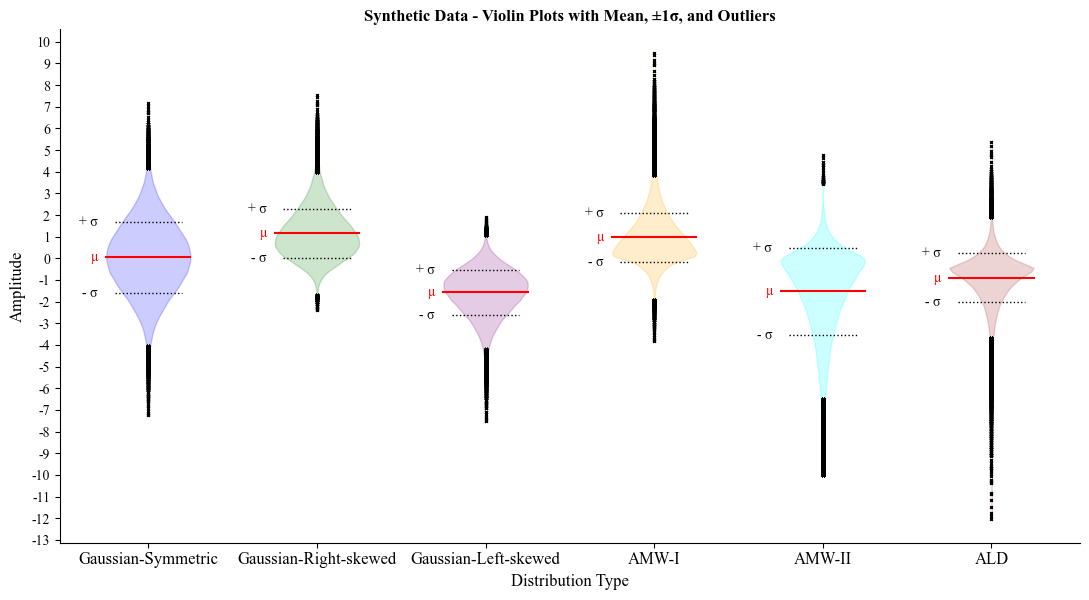

In [21]:
DataColor = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']
DataArrayList = []
for DistName in DIST_USED:
    S = LoadData(DistName, DATA_PATH)
    DataArrayList.append(S)

# Setup figure
fig, ax = plt.subplots(figsize=(11, 6.1))

# Create violin plots (split=False for vertical)
parts = ax.violinplot(DataArrayList, showmeans=False, showmedians=False, showextrema=False)

# Customize violin fill
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(DataColor [i])
    pc.set_alpha(0.2)
    pc.set_edgecolor(DataColor [i])
    pc.set_linewidth(1)

# Add statistics
for i, Arr in enumerate(DataArrayList, start=1):  # violinplot indices start at 1
    mean = np.mean(Arr)
    std = np.std(Arr)

    # Mean line (red)
    ax.plot([i - 0.25, i + 0.25], [mean, mean], color='red', lw=1.5)
    ax.text(i - 0.3, mean, '%s' % GREEK_CHAR['mu'],
            ha='right', va='center', fontdict=FontNorm10, color='r')

    # ±1σ dotted black lines
    ax.plot([i - 0.2, i + 0.2], [mean - std, mean - std], color='k', linestyle='dotted', lw=1)
    ax.text(i - 0.3, mean - std, '- %s' % GREEK_CHAR['sigma'],
            ha='right', va='center', fontdict=FontNorm10, color='k')
    
    ax.plot([i - 0.2, i + 0.2], [mean + std, mean + std], color='k', linestyle='dotted', lw=1)
    ax.text(i - 0.3, mean + std, '+ %s'%GREEK_CHAR['sigma'],
        ha='right', va='center', fontdict=FontNorm10, color='k')

    # Outliers (black 'x') beyond ±2.5σ
    outliers = Arr[(Arr < mean - 2.5*std) | (Arr > mean + 2.5*std)]
    ax.plot(np.full_like(outliers, i), outliers, 'x', color='k',markersize=2)
    
# Axis and labels
ax.set_xticks(range(1, len(DataArrayList) + 1))
# Split into two lines
#xTickLabels = [title for title in DIST_USED]


xTickLabels = [
    "Gaussian-Symmetric",
    "Gaussian-Right-skewed",
    "Gaussian-Left-skewed",
    "AMW-I",
    "AMW-II",
    "ALD"
]

ax.set_xticklabels(xTickLabels, rotation=0, ha='center', fontdict=FontNorm12)
ax.set_xlabel('Distribution Type', fontdict=FontNorm12)
yMin=math.floor(np.amin(DataArrayList))
yMax=math.ceil(np.amax(DataArrayList))+1
yTicks=np.arange(yMin, yMax, dtype=int)
ax.set_yticks(yTicks)
ax.set_yticklabels(["%d"%t for t in yTicks], fontdict=FontNorm10)
ax.set_ylabel('Amplitude', fontdict=FontNorm12)
ax.set_title('Synthetic Data - Violin Plots with Mean, ±1σ, and Outliers',fontdict=SubTitleFont)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig1.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig1.pdf", 
                bbox_inches="tight")

plt.show()

## Load Data from Systolic_Diastolic_Data.xlsx

In [22]:
FilePath = os.path.join(DATA_PATH, REAL_DATA_FILE)

# Load all three sheets into a list of DataFrames
SheetNames = ['2022', '2023', '2024']  # sheet indices: the year of data collected
df_list = [pd.read_excel(FilePath, sheet_name=sh) for sh in SheetNames]

# Extract column 1 (index 0) as systolic and column 2 (index 1) as diastolic
# Concatenate into single 1D NumPy arrays
systolic = np.concatenate([d.iloc[:, 0].to_numpy() for d in df_list])
diastolic = np.concatenate([d.iloc[:, 1].to_numpy() for d in df_list])

print(f"Systolic: {systolic.shape}  Diastolic: {diastolic.shape}")

Systolic: (300000,)  Diastolic: (300000,)


# Violin Plots - Systolic & Diastolic Data

Showing Mean, Std Dev and Outliers

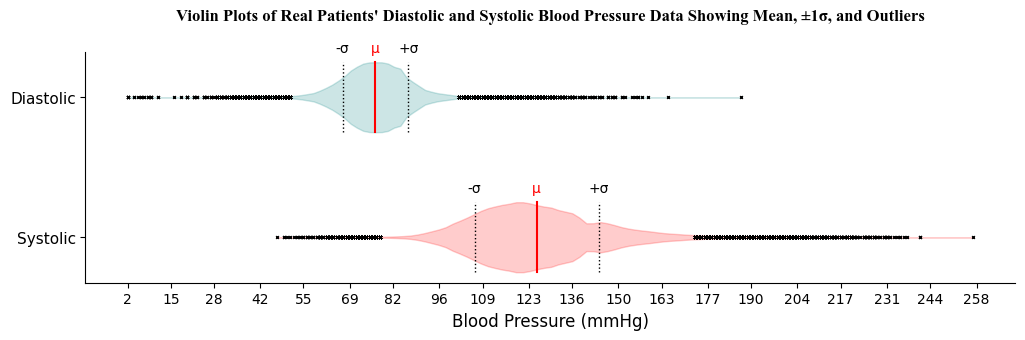

In [23]:
# systolic = ...
# diastolic = ...

DataArrayList = [systolic, diastolic]
DataColor = ['red', 'teal']
yTickLabels = ['Systolic', 'Diastolic']

fig, ax = plt.subplots(figsize=(12, 3))

# Create horizontal violin plots
parts = ax.violinplot(DataArrayList, vert=False, showmeans=False, showmedians=False, showextrema=False)

# Customize violin fill
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(DataColor[i])
    pc.set_alpha(0.2)
    pc.set_edgecolor(DataColor[i])
    pc.set_linewidth(1)

# Add statistics
for i, Arr in enumerate(DataArrayList, start=1):  # violinplot indices start at 1
    mean = np.mean(Arr)
    std = np.std(Arr)

    # Mean line (red)
    ax.plot([mean, mean], [i - 0.25, i + 0.25], color='red', lw=1.5)
    ax.text(mean, i + 0.4, 'μ', ha='center', va='top', fontsize=10, color='r')

    # ±1σ dotted black lines
    ax.plot([mean - std, mean - std], [i - 0.25, i + 0.25], color='k', linestyle='dotted', lw=1)
    ax.text(mean - std, i + 0.4, '-σ', ha='center', va='top', fontsize=10, color='k')
    
    ax.plot([mean + std, mean + std], [i - 0.25, i + 0.25], color='k', linestyle='dotted', lw=1)
    ax.text(mean + std, i + 0.4, '+σ', ha='center', va='top', fontsize=10, color='k')

    # Outliers beyond ±2.5σ
    outliers = Arr[(Arr < mean - 2.5*std) | (Arr > mean + 2.5*std)]
    ax.plot(outliers, np.full_like(outliers, i), 'x', color='k', markersize=2)

# Axis and labels
ax.set_yticks(range(1, len(DataArrayList) + 1))
ax.set_yticklabels(yTickLabels, fontsize=11)
#ax.set_ylabel('Measurement Type', fontsize=12)

xMin = math.floor(np.amin(DataArrayList))
xMax = math.ceil(np.amax(DataArrayList)) + 1
xTicks = np.linspace(xMin, xMax, 20, dtype=int)
ax.set_xticks(xTicks)
ax.set_xlabel('Blood Pressure (mmHg)', fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
Title="Violin Plots of Real Patients' Diastolic and Systolic Blood Pressure Data Showing Mean, ±1σ, and Outliers"
ax.set_title(Title,y=1.1,fontdict=SubTitleFont);
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig2.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig2.pdf", 
                bbox_inches="tight")

plt.show()

## Estimation of Bins Using Freedman Diaconis Rule

In [24]:
nBins= int(BinsFreedmanDiaconisRule(tf.cast(systolic, dtype=tf.float32)))
print("For systolic data - Estimation of Bins Using Freedman Diaconis Rule: ",nBins)
nBins= int(BinsFreedmanDiaconisRule(tf.cast(diastolic, dtype=tf.float32)))
print("For diastolic data - Estimation of Bins Using Freedman Diaconis Rule: ",nBins)


2025-10-02 13:42:26.256256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


For systolic data - Estimation of Bins Using Freedman Diaconis Rule:  293
For diastolic data - Estimation of Bins Using Freedman Diaconis Rule:  477


## Systolic & Diastolic Data - Plot Histogram / PDF

#### Using dprPDF Utilizing Internal Function as KDE / HDE with Polynomial Order 3, 4, & 5 

#### For Baseline Use SciPy KDE

#### Histogram - determines the number of bins using the Freedman-Diaconis Rule 

**NOTE Tensorflow KDE Fails as 

,Distribution,Function,Training,Inference,AUC,JS-Divergence,MSE,Correlation


2025-10-02 13:43:02.451983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


HDE - X:(293,) HDE:(293,) BinWidth: 0.72 - 17144.393 ms
xSciPyKDE:(15000,) SciPyKDE:(15000,)  msTime:15289.63 AUC:1.00


2025-10-02 13:43:35.817273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:43:37.096072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Dummy: pdfFunc:(15000,)  msTrain:1370.52 msTime:83.97


2025-10-02 13:43:37.579311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:43:38.609009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(3) x:(15000,) y:(15000,)  msTrain:1111.79  msTime:67.32  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.993
pdfFunc:(15000,)  msTrain:1111.79 msTime:67.32


2025-10-02 13:43:39.527929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:43:57.695581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(3) x:(15000,) y:(15000,)  msTrain:18239.22  msTime:68.41  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.992
pdfFunc:(15000,)  msTrain:18239.22 msTime:68.41


2025-10-02 13:43:58.617415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:43:59.750828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(4) x:(15000,) y:(15000,)  msTrain:1203.31  msTime:99.40  JSD:0.01 AUC:1.00, MSE:0.000 Corr:0.995
pdfFunc:(15000,)  msTrain:1203.31 msTime:99.40


2025-10-02 13:44:00.699995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:44:18.878382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(4) x:(15000,) y:(15000,)  msTrain:18249.77  msTime:68.87  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.993
pdfFunc:(15000,)  msTrain:18249.77 msTime:68.87


2025-10-02 13:44:19.805338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:44:20.169170: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-10-02 13:44:20.959766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(5) x:(15000,) y:(15000,)  msTrain:1222.98  msTime:82.20  JSD:0.27 AUC:5.05, MSE:0.000 Corr:nan
pdfFunc:(15000,)  msTrain:1222.98 msTime:82.20


2025-10-02 13:44:21.895416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:44:40.149738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(5) x:(15000,) y:(15000,)  msTrain:18329.13  msTime:69.22  JSD:0.01 AUC:0.98, MSE:0.000 Corr:0.996
pdfFunc:(15000,)  msTrain:18329.13 msTime:69.22


2025-10-02 13:44:40.840016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


HDE - X:(477,) HDE:(477,) BinWidth: 0.39 - 17137.053 ms
xSciPyKDE:(15000,) SciPyKDE:(15000,)  msTime:14031.40 AUC:1.00


2025-10-02 13:45:13.042824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:14.256781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Dummy: pdfFunc:(15000,)  msTrain:1312.72 msTime:90.51


2025-10-02 13:45:14.774450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:15.844275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(3) x:(15000,) y:(15000,)  msTrain:1151.49  msTime:68.05  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.990
pdfFunc:(15000,)  msTrain:1151.49 msTime:68.05


2025-10-02 13:45:16.797279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:34.957538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(3) x:(15000,) y:(15000,)  msTrain:18233.31  msTime:69.52  JSD:0.01 AUC:0.98, MSE:0.000 Corr:0.989
pdfFunc:(15000,)  msTrain:18233.31 msTime:69.52


2025-10-02 13:45:35.912651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:37.071039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(4) x:(15000,) y:(15000,)  msTrain:1237.67  msTime:71.08  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.995
pdfFunc:(15000,)  msTrain:1237.67 msTime:71.08


2025-10-02 13:45:38.069742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:56.192476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(4) x:(15000,) y:(15000,)  msTrain:18200.46  msTime:70.28  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.990
pdfFunc:(15000,)  msTrain:18200.46 msTime:70.28


2025-10-02 13:45:57.162508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:45:58.355948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tKDE(5) x:(15000,) y:(15000,)  msTrain:1277.20  msTime:69.75  JSD:0.01 AUC:1.00, MSE:0.000 Corr:0.995
pdfFunc:(15000,)  msTrain:1277.20 msTime:69.75


2025-10-02 13:45:59.326110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:46:17.480107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DPR-tHDE(5) x:(15000,) y:(15000,)  msTrain:18229.67  msTime:71.14  JSD:0.01 AUC:0.99, MSE:0.000 Corr:0.991
pdfFunc:(15000,)  msTrain:18229.67 msTime:71.14


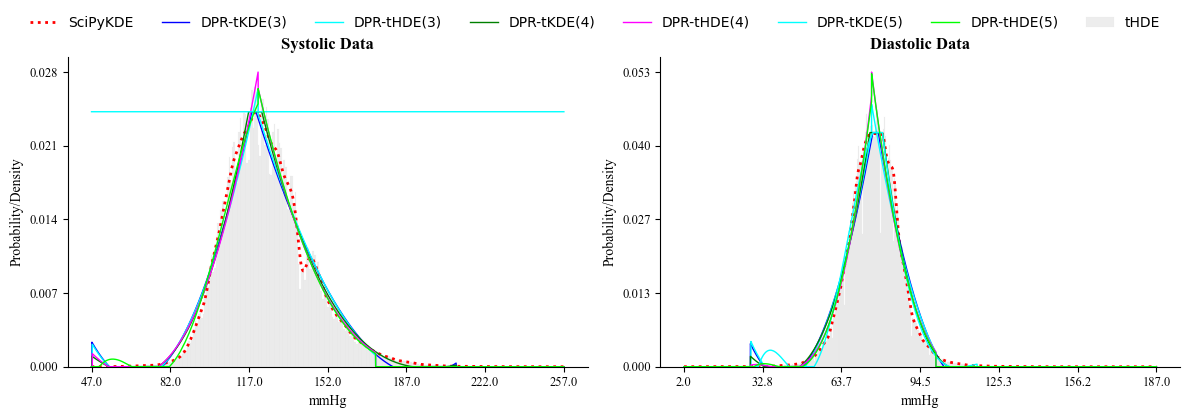

,Distribution,Function,Training,Inference,AUC,JS-Divergence,MSE,Correlation
0,Systolic,HDE,NaN,17144.392967,0.999996,NaN,NaN,NaN
1,Systolic,SciPyKDE,NaN,15289.631128,0.999996,NaN,NaN,NaN
2,Systolic,DPR-tKDE(3),1111.789942,67.317963,0.991805,0.009624,8.538606e-07,0.993145
3,Systolic,DPR-tHDE(3),18239.217997,68.410158,0.986817,0.011654,9.243267e-07,0.992186
4,Systolic,DPR-tKDE(4),1203.312159,99.399805,0.997356,0.005473,5.658105e-07,0.995051
5,Systolic,DPR-tHDE(4),18249.768972,68.865061,0.987844,0.010057,8.015350e-07,0.992601
6,Systolic,DPR-tKDE(5),1222.984076,82.201958,5.050976,0.272896,4.260484e-04,NaN
7,Systolic,DPR-tHDE(5),18329.129934,69.216013,0.983763,0.009574,4.400578e-07,0.995994
8,Diastolic,HDE,NaN,17137.053013,0.999990,NaN,NaN,NaN
9,Diastolic,SciPyKDE,NaN,14031.404972,0.999990,NaN,NaN,NaN


In [25]:
nRealPDF=15000
# Re-assign DataColor for 8 DPR Func 
DataColor = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']

#------------------------------------------------------------ 
# Create empty DataFrame
#------------------------------------------------------------ 
# Define column names
columns = ['Distribution', 'Function', 'Training', 'Inference', 'AUC','JS-Divergence', 'MSE', 'Correlation']  
dfReal = pd.DataFrame(columns=columns)
display(dfReal)
#------------------------------------------------------------ 

# Create 1 row and 2 columns of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))#, sharey=True)   
plt.subplots_adjust(wspace=0.1)# Adjust horizontal space'
DataList=['Systolic', 'Diastolic']
for i, S in enumerate([systolic, diastolic]):
    yMax=0
    xMin=np.amin(S); xMax=np.amax(S)
    xTicks= np.linspace(xMin, xMax, 7) 
    
    #----------------------------------------------------------------
    # Histogram HDE()- Not Providing nBis (Using Freedman–Diaconis rule)
    #----------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf,BinWidth=HDE(S)#, nBins=nRealPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    
    x=X.numpy() if isinstance(X, tf.Tensor) else X
    y=pdf.numpy() if isinstance(pdf, tf.Tensor) else pdf
    y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
    if yMax < np.amax(y): yMax=np.amax(y) # Update yMax
    
    auc=ComputeAUC(x, y)
    
    dfReal = UpdateDf(dfReal, DataList[i], 'HDE', None, msTime, auc, None, None, None)
    print(f'HDE - X:{X.shape} HDE:{pdf.shape} BinWidth: {BinWidth:.2f} - {msTime:.3f} ms')
    
    # Plot Histogram
    ax[i].bar( x,           # Bin centers 
               y,                   # PDF values (heights)
               width=BinWidth,      # Approximate bin width
               align='center',
               alpha=0.5,
               lw=0.1,
               ec='#dcdcdc',        # Very light gray edge color ec='gray',
               fc='#dcdcdc',        #'lightgray',
               label='tHDE') 
    
    #------------------------------------------------------------
    # SciPyKDE()
    #------------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    X, pdf = SciPyKDE(S,Points=nRealPDF)
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds    
    
    x=X.numpy() if isinstance(X, tf.Tensor) else X    
    y=pdf.numpy() if isinstance(pdf, tf.Tensor) else pdf
    y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
    if yMax < np.amax(y): yMax=np.amax(y) # Update yMax
    #**********************************************
    RefPDF=np.array(y); # Use SciPyKDE() as Ref
    #**********************************************
    auc=ComputeAUC(x, y)
    dfReal = UpdateDf(dfReal, DataList[i], 'SciPyKDE', None, msTime, auc, None, None, None)
    print(f'xSciPyKDE:{X.shape} SciPyKDE:{y.shape}  msTime:{msTime:.2f} AUC:{auc:.2f}')
    
    ax[i].plot(x,y,lw=2, ls=':', c='r', label='SciPyKDE') 
    #***********************************************************
    # Here onwards will be using DualPolyRegPDF
    #***********************************************************
    #-------------------------------------------------------
    # Dummy Call - to fix the timing calculation   
    #--------------------------------------------------------
    ResetBackEnd()
    start = time.time()
    F=DualPolyRegPDF(S, Points=1000, PolyOrder=3, TimesStd=PROB_FUNC_TH, UseKDE=True)
    end = time.time()
    msTrain = (end - start) * 1000  # Convert to milliseconds     

    ResetBackEnd()
    start = time.time()
    pdf=F(np.linspace(xMin,xMax,nRealPDF)) # MemFunc
    end = time.time()
    msTime = (end - start) * 1000  # Convert to milliseconds 
    print(f'Dummy: pdfFunc:{pdf.shape}  msTrain:{msTrain:.2f} msTime:{msTime:.2f}')
    #-------------------------------------------
    # Start Plotting drpPDF using KDE & HDE for Orders 3,4,5
    #-------------------------------------------
    x=np.linspace(xMin,xMax,nRealPDF)
    for j, Order in enumerate([3,4,5]):
        for k, (KDE_Flag, InsideFunc) in enumerate(zip([True, False], ['KDE', 'HDE'])):
            ResetBackEnd()
            start = time.time()
            F=DualPolyRegPDF(S,Points=1000,PolyOrder=Order,TimesStd=PROB_FUNC_TH,UseKDE=KDE_Flag,RetProb=False)
            end = time.time()
            msTrain = (end - start) * 1000  # Convert to milliseconds 
            
            ResetBackEnd()
            
            start = time.time()
            pdf=F(x) # MemFunc
            end = time.time()
            msTime = (end - start) * 1000  # Convert to milliseconds 
            
            y=pdf.numpy() if isinstance(pdf, tf.Tensor) else pdf
            y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
            if yMax < np.amax(y): yMax=np.amax(y) # Update yMax

            auc=ComputeAUC(x, y)
            jsd=ComputeJSD(RefPDF,y)
            mse=tf.reduce_mean(tf.square(RefPDF - y))
            corr=ComputePearsonCorr(RefPDF, y)
            Label='DPR-t%s(%d)'%(InsideFunc, Order)
            dfReal = UpdateDf(dfReal, DataList[i], Label, msTrain, msTime, auc, jsd, mse, corr)

            print(f'{Label} x:{x.shape} y:{y.shape}  msTrain:{msTrain:.2f}  msTime:{msTime:.2f} ',
                  f'JSD:{jsd:.2f} AUC:{auc:.2f}, MSE:{mse:.3f} Corr:{corr:.3f}')

            
            print(f'pdfFunc:{pdf.shape}  msTrain:{msTrain:.2f} msTime:{msTime:.2f}')


            ax[i].plot(x,y, c=POLY_ORDER_COLORS[k*2+j], lw=1, label=Label)
    #-------------------------------------------
    # Set x Axis 
    ax[i].set_xticks(xTicks)
    ax[i].set_xticklabels(['%.1f'%t for t in xTicks], fontdict=FontNorm9)
    ax[i].set_xlabel("mmHg", fontdict=FontNorm10)
    # Set y Axis
    yTicks=np.linspace(0, yMax, 5)
    ax[i].set_yticks(yTicks)
    ax[i].set_yticklabels(['%.3f'%t for t in yTicks], fontdict=FontNorm9)
    ax[i].set_ylabel("Probability/Density", fontdict=FontNorm10)
    # Hide Spines  & Set Title 
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].set_title(f'{DataList[i]} Data', fontdict=SubTitleFont) 
    #break
#----------------------------------------------------------------------------- 
# Common legend:
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=10, 
           frameon=False, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig6.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig6.pdf", 
                bbox_inches="tight")

plt.show()

#----------------------------------------------------------------------------- 
display(dfReal)
#----------------------------------------------------------------------------- 

if SAVE_FILES:
    # Save subset where Distribution == 'Systolic'
    dfReal[dfReal['Distribution'] == 'Systolic'].to_csv(METRICS_PATH+"/SystolicMetrics.csv", index=False)

    # Save subset where Distribution == 'Diastolic'
    dfReal[dfReal['Distribution'] == 'Diastolic'].to_csv(METRICS_PATH+"/DiastolicMetrics.csv", index=False)



## For Testing - Calling DPR to Prob instead of Func

In [26]:
if TEST_CODE:
    # Re-assign DataColorfor 6 
    DataColor = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']

    # Create 1 row and 2 columns of subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))#, sharey=True)   
    plt.subplots_adjust(wspace=0.1)# Adjust horizontal space'
    DataList=['Systolic', 'Diastolic']
    for i, S in enumerate([systolic, diastolic]):
        yMax=0
        xMin=np.amin(S); xMax=np.amax(S)
        xTicks= np.linspace(xMin, xMax, 7) 
        ResetBackEnd()
        start = time.time()
        x,y,BinWidth=HDE(S)
        end = time.time()
        msTime = (end - start) * 1000  # Convert to milliseconds 
        x=x.numpy(); y=y.numpy()
        y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
        if yMax < np.amax(y): yMax=np.amax(y) # Update yMax
        # Plot Histogram
        ax[i].bar( x,           # Bin centers 
                   y,                   # PDF values (heights)
                   width=BinWidth,      # Approximate bin width
                   align='center',
                   alpha=0.5,
                   lw=0.1,
                   ec='#dcdcdc',        # Very light gray edge color ec='gray',
                   fc='#dcdcdc',        #'lightgray',
                   label='HDE') 
        print(f'HDE - x:{x.shape} y:{y.shape} BinWidth: {BinWidth:.2f} - {msTime:.3f} ms')
        #-------------------------------------------
        # Start Plotting drpPDF using KDE & HDE for Orders 3,4,5
        #-------------------------------------------
        for j, Order in enumerate([3,4,5]):
            for k, (KDE_Flag, InsideFunc) in enumerate(zip([True, False], ['KDE', 'HDE'])):
                ResetBackEnd()
                start = time.time()
                x,y=DualPolyRegPDF(S,Points=nPDF,PolyOrder=Order,TimesStd=PROB_FUNC_TH,UseKDE=KDE_Flag,RetProb=True)

                end = time.time()
                print(f"nPDF:{nPDF} x:{x.shape} y:{y.shape}")

                msTime = (end - start) * 1000  # Convert to milliseconds 
                x=x.numpy(); y=y.numpy()
                print(f"nPDF:{nPDF} x:{x.shape} y:{y.shape}")
                y = np.where(np.isinf(y), np.max(y[np.isfinite(y)]) * 2, y)
                if yMax < np.amax(y): yMax=np.amax(y) # Update yMax            
                Label='DPR-%s (O=%d)'%(InsideFunc, Order)
                ax[i].plot(x,y, c=POLY_ORDER_COLORS[k*2+j], lw=1, label=Label)
                print(f'{Label} - x:{x.shape} y:{y.shape} - {msTime:.3f} ms')
        #-------------------------------------------
        # Set x Axis 
        ax[i].set_xticks(xTicks)
        ax[i].set_xticklabels(['%.1f'%t for t in xTicks], fontdict=FontNorm9)
        ax[i].set_xlabel("mmHg", fontdict=FontNorm10)
        # Set y Axis
        yTicks=np.linspace(0, yMax, 5)
        ax[i].set_yticks(yTicks)
        ax[i].set_yticklabels(['%.3f'%t for t in yTicks], fontdict=FontNorm9)
        ax[i].set_ylabel("Probability/Density", fontdict=FontNorm10)
        # Hide Spines  & Set Title 
        ax[i].spines[['top', 'right']].set_visible(False)
        ax[i].set_title(f'{DataList[i]} Data', fontdict=SubTitleFont) 
        #break
    #----------------------------------------------------------------------------- 
    # Common legend:
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=7, fontsize=10, 
               frameon=False, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout()
    plt.show()



## Sample Wise Probbabilty - 'Systolic', 'Diastolic' Data

### Sample Size: 1000
    
**Baseline: KDE()**   

Compared dprPDF() utilizing KDE() & HDE() with Polynomial Orders 3 & 4

**Metrics: JS - Divergence**

#### Metrics will be saved in jsdList

**jsdList[0]: For Systolic Data**

**jsdList[1]: For Diastolic Data**

- jsdList[i][0]- Polynomial Order: 3 | Internal Function: KDE()
- jsdList[i][1]- Polynomial Order: 3 | Internal Function: HDE()
- jsdList[i][2]- Polynomial Order: 4 | Internal Function: KDE()
- jsdList[i][3]- Polynomial Order: 4 | Internal Function: HDE()


In [27]:
DataList=['Systolic', 'Diastolic']
## Metrics will be saved in jsdList
## jsdList[0]: For Systolic Data
## jsdList[1]: For Diastolic Data

jsdList=[[],[]] 
TrainTimeList=[[],[]] 
InferTimeList=[[],[]] 
TimeConvKDE={}
JSD_SciPyKDE_KDE={}
for i, S in enumerate([systolic, diastolic]):
    # Trim S to make length divisible by W if needed
    W=1000 ; N=S.size; M=N//W
    sTrimmed = S[:M*W]
    # Reshape to (M, W)
    sWin = sTrimmed.reshape(M, W)
    print(f"{i} N:{N}. W:{W} M:{M}  sTrimmed:{sTrimmed.shape} sWin:{sWin.shape}")

    ySciPyKDE=np.zeros(sWin.shape)
    start = time.time()
    for m in range(M):
        w=sWin[m,:]
        _, ySciPyKDE[m,:] = SciPyKDE(S,s=w)
    end = time.time()
    PTime = (end - start) # In seconds 
    print(f"ySciPyKDE:{ySciPyKDE.shape}  msTime:{PTime:.3f}ms")
    TimeConvKDE[f"{DataList[i]}-SciPyKDE"]= PTime
    
    
    yKDE=np.zeros(sWin.shape)
    start = time.time()
    for m in range(M):
        w=sWin[m,:]
        _, yKDE[m,:] = KDE(S,s=w)
    end = time.time()
    PTime = (end - start)   # In seconds 
    print(f"yKDE:{yKDE.shape}  msTime:{PTime:.3f}ms")
    TimeConvKDE[f"{DataList[i]}-KDE"]= PTime
    JSD_SciPyKDE_KDE[DataList[i]]=ComputeJSD(yKDE,ySciPyKDE)
    #-------------------------------------------
    # Start Plotting drpPDF using KDE & HDE for Orders 3,4,5
    #-------------------------------------------
    y_dprPDF=np.zeros((2, 2, M, W))
    for j, Order in enumerate([3,4]):
        for k, (KDE_Flag, InsideFunc) in enumerate(zip([True, False], ['KDE', 'HDE'])):
            ResetBackEnd()
            start = time.time()
            dprPDF_KDE_Func=DualPolyRegPDF(S,Points=nPDF,PolyOrder=Order,TimesStd=PROB_FUNC_TH,UseKDE=KDE_Flag)
            end = time.time()
            TrainTime = (end - start)  # seconds 
            TrainTimeList[i].append(TrainTime)
            start = time.time()
            y_dprPDF[j,k]= dprPDF_KDE_Func(sWin)
            end = time.time()
            InferTime = (end - start)*1000  # msec 
            InferTimeList[i].append(InferTime)
            
            jsdList[i].append(ComputeJSD(yKDE,y_dprPDF[j,k]))
            print(f"Order:{Order} {InsideFunc}-Train Time: {TrainTime:.3f}ms ",
                  f"Inference Time: {InferTime:.3f}ms JSD Mean: {np.mean(jsdList[i][-1]):.3f}")
    
    

0 N:300000. W:1000 M:300  sTrimmed:(300000,) sWin:(300, 1000)
ySciPyKDE:(300, 1000)  msTime:407.857ms


2025-10-02 13:53:07.839977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


yKDE:(300, 1000)  msTime:13.927ms


2025-10-02 13:53:22.465914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:53:26.935626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:3 KDE-Train Time: 4.718ms  Inference Time: 185.927ms JSD Mean: 0.017


2025-10-02 13:53:27.818561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:53:46.068146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:3 HDE-Train Time: 18.521ms  Inference Time: 88.013ms JSD Mean: 0.030


2025-10-02 13:53:46.878860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:53:49.059827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:4 KDE-Train Time: 2.383ms  Inference Time: 159.996ms JSD Mean: 0.016


2025-10-02 13:53:49.854719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 13:54:08.128460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:4 HDE-Train Time: 18.552ms  Inference Time: 83.048ms JSD Mean: 0.028
1 N:300000. W:1000 M:300  sTrimmed:(300000,) sWin:(300, 1000)
ySciPyKDE:(300, 1000)  msTime:405.654ms


2025-10-02 14:00:54.117926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


yKDE:(300, 1000)  msTime:12.721ms


2025-10-02 14:01:07.316024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 14:01:10.758097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:3 KDE-Train Time: 3.650ms  Inference Time: 146.946ms JSD Mean: 0.022


2025-10-02 14:01:11.575817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 14:01:29.780708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:3 HDE-Train Time: 18.485ms  Inference Time: 92.421ms JSD Mean: 0.046


2025-10-02 14:01:30.583539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 14:01:32.799575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:4 KDE-Train Time: 2.403ms  Inference Time: 173.580ms JSD Mean: 0.021


2025-10-02 14:01:33.593050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-02 14:01:51.859970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Order:4 HDE-Train Time: 18.540ms  Inference Time: 84.083ms JSD Mean: 0.043


## Comparing SciPy KDE vs TensorFlow KDE

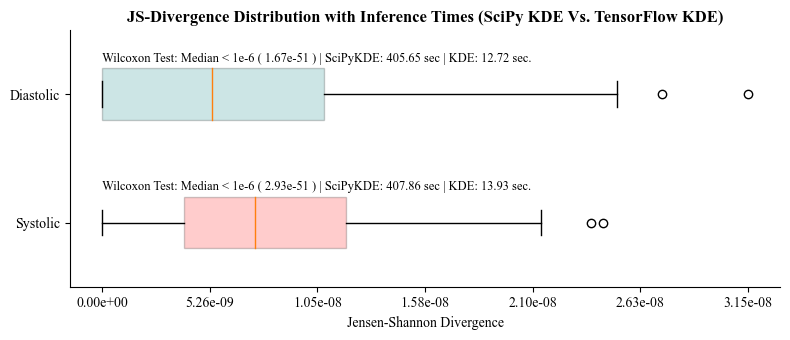

In [32]:
# Prepare data
DataList = ["Systolic", "Diastolic"]
data = [JSD_SciPyKDE_KDE["Systolic"], JSD_SciPyKDE_KDE["Diastolic"]]
pVal = {}
xMin = np.inf       # positive infinity
xMax = -np.inf      # negative infinity
#------------------------------------------
for i, value in enumerate(data): 
    # One-sided Wilcoxon test for median < 1e-6
    _, p = wilcoxon(value - 1e-6, alternative="less")
    pVal[DataList[i]] = p
    if np.amin(value)<xMin: xMin=np.amin(value)
    if np.amax(value)>xMax: xMax=np.amax(value)
#------------------------------------------        
fig, ax = plt.subplots(figsize=(8, 3.5))
# Horizontal boxplot
box = ax.boxplot(data, vert=False, patch_artist=True, labels=DataList, widths=0.4 )
#------------------------------------------
# Colors for clarity
DataColor = ['red', 'teal']
for patch, color in zip(box["boxes"], DataColor):
    patch.set_facecolor(color)
    patch.set_alpha(0.2)   # <-- transparency
#------------------------------------------
# Add inference times above each box
for i, label in enumerate(DataList, start=1):
    scipyT = TimeConvKDE[f"{label}-SciPyKDE"]
    kdeT = TimeConvKDE[f"{label}-KDE"]
    ax.text(
        x=np.min(data[i-1]),   # place text around median
        y=i+0.25,                 # a little above the box
        s=f"Wilcoxon Test: Median < 1e-6 ( {pVal[DataList[i-1]]:.2e} ) | SciPyKDE: {scipyT:.2f} sec | KDE: {kdeT:.2f} sec.",
        ha="left",
        fontdict=FontNorm9,
        color="black"
    )
#------------------------------------------
ax.set_title("JS-Divergence Distribution with Inference Times (SciPy KDE Vs. TensorFlow KDE)", fontdict=SubTitleFont)
xTicks=np.linspace(xMin, xMax,7)
ax.set_xticks(xTicks)
ax.set_xticklabels([f'{t:.2e}' for t in xTicks], fontdict=FontNorm10)

ax.set_xlabel("Jensen-Shannon Divergence", fontdict=FontNorm10)
ax.set_yticklabels(DataList, fontdict=FontNorm10)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
if 1:#SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig7.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig7.pdf", 
                bbox_inches="tight")


plt.show()


## Plotting Jensen-Shannon Divergence Comparisons for Systolic and Diastolic Data

This code prepares and visualizes the Jensen-Shannon Divergence (JSD) results for different probability estimation methods applied to systolic and diastolic data sets. The create_dataframe function reshapes the data into a tidy format suitable for Seaborn plotting. Two side-by-side subplots display boxplots overlaid with swarmplots to illustrate the distribution and individual values of JSD across four estimation groups. The visualizations highlight comparative performance.

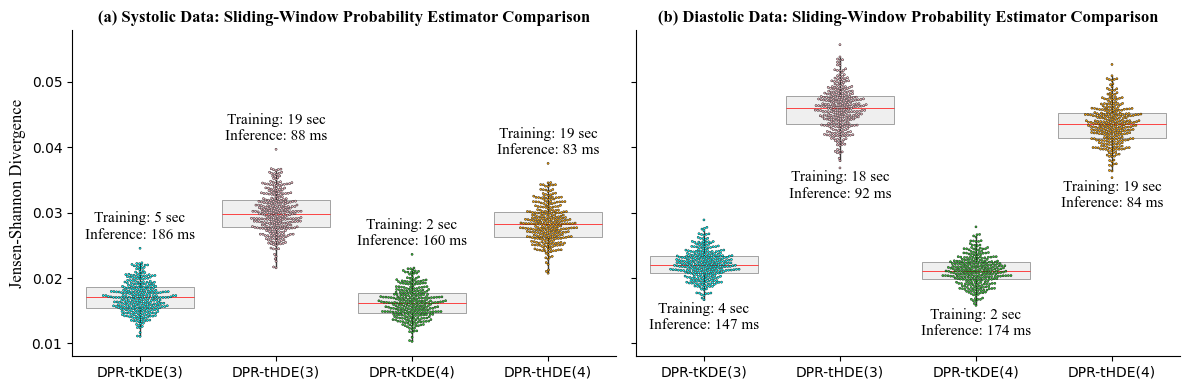

[185.93  88.01 160.    83.05 146.95  92.42 173.58  84.08]
Inference time - Mean:126.75 sd:41.26 


In [31]:
#----------------------------------------------------------------
def create_dataframe(data_list, labels):
    # Flatten and create a DataFrame suitable for seaborn
    values = np.concatenate(data_list)
    group_labels = np.concatenate([[label]*len(arr) for label, arr in zip(labels, data_list)])
    return pd.DataFrame({'Value': values, 'Group': group_labels})
#----------------------------------------------------------------

# Labels for groups
#labels = ['Order 3 | KDE', 'Order 3 | HDE', 'Order 4 | KDE', 'Order 4 | HDE']
labels = ['DPR-tKDE(3)', 'DPR-tHDE(3)', 'DPR-tKDE(4)', 'DPR-tHDE(4)']
Colors = ['cyan', 'pink', 'limegreen', 'orange']  # Colors for Groups
#----------------------------------------------------------------
# Seperate the Metrics in two sets
Systolic_Set = jsdList[0]
Diastolic_Set = jsdList[1]
# Create dataframes for plotting
dfSystolic = create_dataframe(Systolic_Set, labels)
dfDiastolic = create_dataframe(Diastolic_Set, labels)
#----------------------------------------------------------------

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)# Adjust horizontal space'
#*************************************************************
# Plot for JSD-Based Estimator Comparison for Systolic Data
#*************************************************************
sns.boxplot(
    x='Group',
    y='Value',
    hue='Group',     # tell Seaborn the palette applies to this variable
    data=dfSystolic,
    ax=ax[0],
    showcaps=False,
    showfliers=False, # (0.8, 0.8, 0.8, 0.3): Light Gray Alpha=0.3
    boxprops={'facecolor': (0.8, 0.8, 0.8, 0.3), 'edgecolor': 'gray', 'linewidth': 0.5},  # box outline
    medianprops={'color': 'red', 'linewidth': 0.5},                                       # median line
    capprops={'color': 'black', 'linewidth': 1.2}                                         # caps

)
#----------------------------------------------------------------
sns.swarmplot(
    x='Group',
    y='Value',
    hue='Group',     # tell Seaborn the palette applies to this variable
    data=dfSystolic,
    ax=ax[0],
    size=1.5,
    palette=Colors,
    linewidth=0.3,    # edge line width for each point
    edgecolor='black', # optional, to make points stand out
    dodge=False,
    legend=False     # avoid duplicate legends
)
#----------------------------------------------------------------
# Print the Total Execution Time 
TrainTime_s=np.array(TrainTimeList[0])
InferTime_ms=np.array(InferTimeList[0])

# Loop thru  unique group labels in order from the dataframe
for i, group in enumerate(dfSystolic['Group'].unique()):
    # Extract y-values for this group
    y_vals = dfSystolic.loc[dfSystolic['Group'] == group, 'Value']
    y_max = y_vals.max()
    
    # Text position: center horizontally at i, y position 1.1 * max y
    ax[0].text(i, y_max + 0.001, 
               f"Training: {TrainTime_s[i]:.0f} sec\nInference: {InferTime_ms[i]:.0f} ms",  
               ha='center', va='bottom', fontdict=FontNorm11)
#----------------------------------------------------------------
ax[0].set_xlabel('')
ax[0].spines[['top', 'right']].set_visible(False)
ax[0].set_title('(a) Systolic Data: Sliding-Window Probability Estimator Comparison', fontdict=SubTitleFont)  
#*************************************************************
# Plot for JSD-Based Estimator Comparison for Diastolic Data
#*************************************************************
sns.boxplot(
    x='Group',
    y='Value',
    hue='Group',     # tell Seaborn the palette applies to this variable
    data=dfDiastolic,
    ax=ax[1],
    showcaps=False,
    showfliers=False, # (0.8, 0.8, 0.8, 0.3): Light Gray Alpha=0.3
    boxprops={'facecolor': (0.8, 0.8, 0.8, 0.3), 'edgecolor': 'gray', 'linewidth': 0.5},  # box outline
    medianprops={'color': 'red', 'linewidth': 0.5},                                       # median line
    capprops={'color': 'black', 'linewidth': 1.2}                                         # caps

)
#----------------------------------------------------------------
sns.swarmplot(
    x='Group',
    y='Value',
    hue='Group',     # tell Seaborn the palette applies to this variable
    data=dfDiastolic,
    ax=ax[1],
    size=1.5,
    palette=Colors,
    linewidth=0.3,    # edge line width for each point
    edgecolor='black', # optional, to make points stand out
    dodge=False,
    legend=False     # avoid duplicate legends
)
#----------------------------------------------------------------
# Print the Total Execution Time 
TrainTime_s=np.array(TrainTimeList[1])
InferTime_ms=np.array(InferTimeList[1])

# Loop thru  unique group labels in order from the dataframe
for i, group in enumerate(dfDiastolic['Group'].unique()):
    # Extract y-values for this group
    y_vals = dfDiastolic.loc[dfDiastolic['Group'] == group, 'Value']
    y_min = y_vals.min()
    # Text position: center horizontally at i, y position 1.1 * max y
    ax[1].text(i, y_min - 0.005, 
               f"Training: {TrainTime_s[i]:.0f} sec\nInference: {InferTime_ms[i]:.0f} ms",  
               ha='center', va='bottom', fontdict=FontNorm11)
#----------------------------------------------------------------

ax[1].set_xlabel('')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].set_title('(b) Diastolic Data: Sliding-Window Probability Estimator Comparison', fontdict=SubTitleFont)#, y=0.99)    
#----------------------------------------------------------------
ax[0].set_ylabel('Jensen-Shannon Divergence', fontdict=FontNorm12)
plt.tight_layout()
if SAVE_FILES:
    # Save with high resolution (e.g., 600 dpi, PDF + PNG)
    plt.savefig(FIG_SAVE_PATH+"Fig8.png", 
                dpi=600, bbox_inches="tight")
    plt.savefig(FIG_SAVE_PATH+"Fig8.pdf", 
                bbox_inches="tight")

plt.show()
#----------------------------------------------------------------
infrT=np.array(InferTimeList).flatten()
print(np.round(infrT,2))
print(f"Inference time - Mean:{np.mean(infrT):.2f} sd:{np.std(infrT):.2f} ")


## Non-Parametric Statistical Comparison of KDE Estimators 

### Mann–Whitney U Test

This code performs a one-sided Mann–Whitney U test to compare the Jensen-Shannon Divergence (JSD) distributions between 'Order 3 | KDE' and 'Order 4 | KDE' groups for both systolic and diastolic datasets. The test evaluates whether the median JSD for 'Order 4 | KDE' is significantly lower than that for 'Order 3 | KDE', indicating improved estimation performance. The results include the U statistic, p-value, and interpretation of statistical significance at the 0.01 level.

In [30]:
def MannWhitneyUTest(df, Type="KDE", alpha=SIGNIFICANT_ALPHA):
    # Construct group names dynamically
    g3 = f"Order 3 | {Type}"
    g4 = f"Order 4 | {Type}"

    O3 = df.loc[df['Group'] == g3, 'Value']
    O4 = df.loc[df['Group'] == g4, 'Value']

    stat, pval = mannwhitneyu(O4, O3, alternative='less')

    print(f"Mann–Whitney U statistic: {stat:.3f}")
    print(f"One-sided p-value: {pval:.2e}")

    if pval < alpha:
        print(f"Reject H₀: {g4} has significantly lower median than {g3}")
    else:
        print(f"Fail to reject H₀: No significant evidence {g4} has lower median")

#**************************
# Non Parametric Test - Systolic Data - backend KDE
print(f"\nMann–Whitney U Test for Systolic Data - JSD")
MannWhitneyUTest(dfSystolic, alpha=SIGNIFICANT_ALPHA)
#**************************
# Non Parametric Test - Diastolic Data - backend KDE
print(f"\nMann–Whitney U Test for Diastolic Data - JSD")
MannWhitneyUTest(dfDiastolic, alpha=SIGNIFICANT_ALPHA)

#**************************
# Non Parametric Test - Systolic Data - backend HDE
print(f"\nMann–Whitney U Test for Systolic Data - JSD")
MannWhitneyUTest(dfSystolic, Type="HDE", alpha=SIGNIFICANT_ALPHA)
#**************************
# Non Parametric Test - Diastolic Data - backend HDE
print(f"\nMann–Whitney U Test for Diastolic Data - JSD")
MannWhitneyUTest(dfDiastolic, Type="HDE", alpha=SIGNIFICANT_ALPHA)




Mann–Whitney U Test for Systolic Data - JSD
Mann–Whitney U statistic: 36325.000
One-sided p-value: 2.20e-05
Reject H₀: Order 4 | KDE has significantly lower median than Order 3 | KDE

Mann–Whitney U Test for Diastolic Data - JSD
Mann–Whitney U statistic: 33957.000
One-sided p-value: 9.90e-08
Reject H₀: Order 4 | KDE has significantly lower median than Order 3 | KDE

Mann–Whitney U Test for Systolic Data - JSD
Mann–Whitney U statistic: 31468.000
One-sided p-value: 9.24e-11
Reject H₀: Order 4 | HDE has significantly lower median than Order 3 | HDE

Mann–Whitney U Test for Diastolic Data - JSD
Mann–Whitney U statistic: 25770.000
One-sided p-value: 6.68e-20
Reject H₀: Order 4 | HDE has significantly lower median than Order 3 | HDE
